# 1 Data Wrangling<a id='1_data_wrangling'></a>

In [1]:
# Import external libraries
import os
import sys
from datetime import datetime, date
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import local libraries
sys.path.append('..') # Add parent folder for local library imports

# Feature creation functions
from src.features.make_features import *
# Helper functions
from src.utils.helpers import *
# Visualization functions
from src.visuals.make_plots import *
# Import API key
from src.utils.params import lunar_api_key

# Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## 1.1 Data Collection

The goal of this project is to build a "Crypto"currency Investment recommendation dashboard.  I will be focusing on short-term 7 day rolling window holding period.  I'm fascinated by the social aspect of crypto price influence and my research on this topic landed on [LunarCRUSH](https://lunarcrush.com/about).  LunarCRUSH delivers community insights to crypto investors, funds and exchanges.  Through resource applications and API's, get real-time insights that help make informed crypto investment decisions."  I will be using the assets API endpoint from LunarCRUSH and technical analysis metrics/indicators to make Buy/Hold/Sell recommendations.

In [3]:
# Create base lunarcrush api url
base_url = 'https://api.lunarcrush.com/v2?'

In [4]:
market_params = {'data': 'market',
                 'key': lunar_api_key
                }

market = requests.get(base_url, params=market_params).json()

all_coins = [i['s'] for i in market['data']]

print(len(all_coins))

2335


I will focus on the following 2 coins for this project:

1. Bitcoin (BTC)
2. Dogecoin (DOGE)

Bitcoin is the first decentralized cryptocurrency created in 2009.  Dogecoin is a memecoin that was originally created as a joke but has been in the social media based on support from influencer Elon Musk, Tesla CEO.

In [5]:
# Validate coin symbols exist in data
coins = ['BTC', 'DOGE']
[coin for coin in all_coins if coin in coins]

['BTC', 'DOGE']

In [6]:
# Create api params for assets endpoint
assets_params = {'data': 'assets',
                 'key': lunar_api_key,
                 'symbol': ",".join(coins),
                 'interval': 'day',
                 'change': '1d',
                 'data_points': 720}

# Get asset data
assets = requests.get(base_url, params=assets_params).json()

The current price and market data is stored in the data key and historical data is stored in the timeSeries key.

In [7]:
# Create DataFrame for each coin and store in dictionary
dfs = {}
for i in range(len(coins)):
    df = pd.DataFrame(assets['data'][i]['timeSeries'])
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('date', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df['name'] = assets['data'][i]['name']
    symbol = assets['data'][i]['symbol']
    df['symbol'] = symbol
    # Store df in dictionary
    dfs[symbol] = df

## 1.2 Data Definition

In [8]:
for coin in coins:
    print(coin,':')
    print(dfs[coin].info())
    print('------------------------------------------')

BTC :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2019-08-05 to 2021-07-24
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 720 non-null    int64  
 1   time                     720 non-null    int64  
 2   open                     720 non-null    float64
 3   close                    720 non-null    float64
 4   high                     720 non-null    float64
 5   low                      720 non-null    float64
 6   volume                   720 non-null    float64
 7   market_cap               683 non-null    float64
 8   url_shares               697 non-null    float64
 9   unique_url_shares        697 non-null    float64
 10  reddit_posts             720 non-null    int64  
 11  reddit_posts_score       720 non-null    int64  
 12  reddit_comments          720 non-null    int64  
 13  reddit_comments_score    720 non-null    int64  
 14  t

##### LunarCrush API field descriptions

| Column   |      Description      |
|:----------|:-------------|
| asset_id |  The LunarCRUSH id for an asset/coin |
| time |    A unix timestamp (in seconds)   |
| open | Open price for the time period |
| close | Close price for the time period |
| high | Highest price for the time period |
| low | Lowest price for the time period |
| volume | Volume for the time period in USD |
| market_cap | Total available supply multiplied by the current price in USD |
| url_shares | Number of urls shared and collected on social |
| unique_url_shares | Number of unique url shares posted and collected on social |
| reddit_posts | Number of reddit posts collected |
| reddit_posts_score | Sum of reddit karma on social posts |
| reddit_comments | Number of reddit comments collected |
| reddit_comments_score | Sum of reddit karma on collected comments |
| tweets | Number of tweets collected |
| tweets_spam | Number of tweets classified as spam |
| tweets_followers | Sum of follower count for every tweet collected |
| tweet_quotes | Sum of the number of times all collected tweets were quoted |
| tweet_retweets | Sum of the number of times all collected tweets were retweeted |
| tweet_replies | Sum of the number of times all collected tweet reply counts |
| tweet_favorites | Sum of the number of times all collected tweet likes |
| tweet_sentiment1 | Sum of tweets classified as sentiment 1 (Very Bearish) |
| tweet_sentiment2 | Sum of tweets classified as sentiment 2 (Bearish) |
| tweet_sentiment3 | Sum of tweets classified as sentiment 3 (Neutral) |
| tweet_sentiment4 | Sum of tweets classified as sentiment 4 (Bullish) |
| tweet_sentiment5 | Sum of tweets classified as sentiment 5 (Very Bullish) |
| tweet_sentiment_impact1 | Sum of social score (engagement) of all tweets classified as sentiment 1 (Very Bearish) |
| tweet_sentiment_impact2 | Sum of social score (engagement) of all tweets classified as sentiment 2 (Bearish) |
| tweet_sentiment_impact3 | Sum of social score (engagement) of all tweets classified as sentiment 3 (Neutral) |
| tweet_sentiment_impact4 | Sum of social score (engagement) of all tweets classified as sentiment 4 (Bullish) |
| tweet_sentiment_impact5 | Sum of social score (engagement) of all tweets classified as sentiment 5 (Very Bullish) |
| social_score | Sum of followers, retweets, likes, reddit karma etc of social posts collected |
| average_sentiment | Average sentiment of collected social posts |
| sentiment_absolute | Percent of bullish or very bullish tweets |
| sentiment_relative | Percent tweets that are bullish (excluding neutral in the count) |
| news | Number of news articles published |
| price_score | A proprietary score based mostly on the change in MACD over time |
| social_impact_score | A proprietary score based on the relative trend of social_score |
| correlation_rank | A score based on how the assets social metrics correlate with price and volume |
| galaxy_score | A proprietary score based on technical indicators of price, average social sentiment, relative social activity, and a factor of how closely social indicators correlate with price and volume |
| volatility | Fegree of variation of a trading price series over time as measured by the standard deviation of logarithmic returns |
| alt_rank | A proprietary score based on how an asset is performing relative to all other assets supported |
| alt_rank_30d | AltRank™ but using 30 day metrics instead of 24 hour metrics |
| market_cap_rank | Position/rank of the asset relative to all other supported assets, lower is better |
| percent_change_24h_rank | Position/rank of the assets percent change in 24 hours, lower is better (positive percent change) |
| volume_24h_rank | Position/rank of the assets 24 hour volume in USD relative to all other supported assets, lower is more volume |
| social_volume_24h_rank | Position/rank of the assets 24 hour social volume relative to all other supported assets, lower is most volume |
| social_score_24h_rank | Position/rank of the assets 24 hour social score relative to all other supported assets, lower is best/highest social score |
| social_contributors | The number of unique accounts posting on social |
| social_volume | Number of social posts |
| price_btc | Current price in BTC |
| percent_change_24h | Percent change in price since 24 hours ago |

The maximum history for the lunarCRUSH API is 720 data points but several social media metrics are missing values.  Let's explore that next.

In [9]:
# Gather unique list of columns with missing values
blanks = []
for coin in coins:
    blanks.append(dfs[coin].columns[dfs[coin].isna().any()].tolist())
blanks_set = set([item for sublist in blanks for item in sublist])
blanks_set

{'alt_rank',
 'alt_rank_30d',
 'alt_rank_hour_average',
 'average_sentiment',
 'correlation_rank',
 'galaxy_score',
 'market_cap',
 'market_cap_global',
 'market_cap_rank',
 'market_dominance',
 'medium',
 'news',
 'percent_change_24h_rank',
 'price_score',
 'search_average',
 'sentiment_absolute',
 'sentiment_relative',
 'social_dominance',
 'social_impact_score',
 'social_score',
 'social_score_24h_rank',
 'social_volume_24h_rank',
 'social_volume_global',
 'tweet_favorites',
 'tweet_followers',
 'tweet_quotes',
 'tweet_replies',
 'tweet_retweets',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment3',
 'tweet_sentiment4',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact3',
 'tweet_sentiment_impact4',
 'tweet_sentiment_impact5',
 'tweet_spam',
 'tweets',
 'unique_url_shares',
 'url_shares',
 'volatility',
 'volume_24h_rank',
 'youtube'}

Plot time series plots for the columns with missing values.

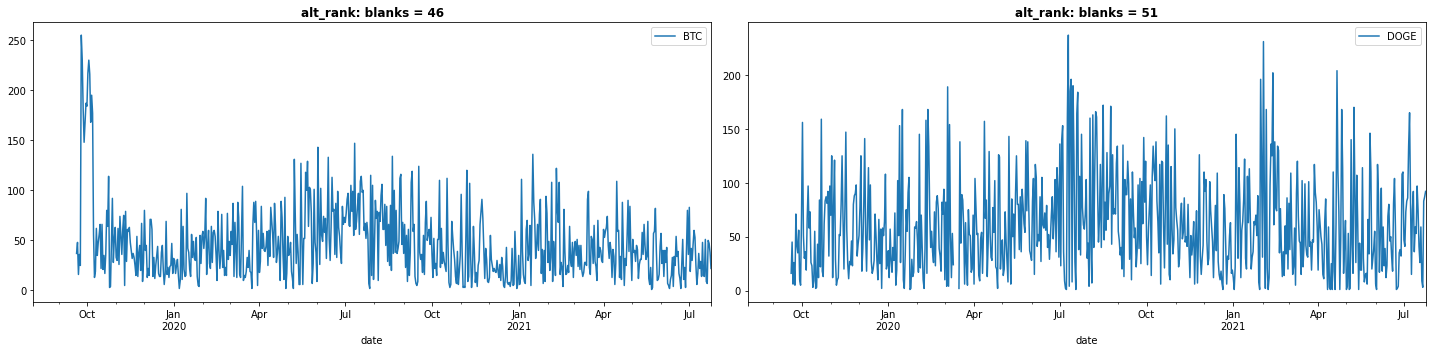

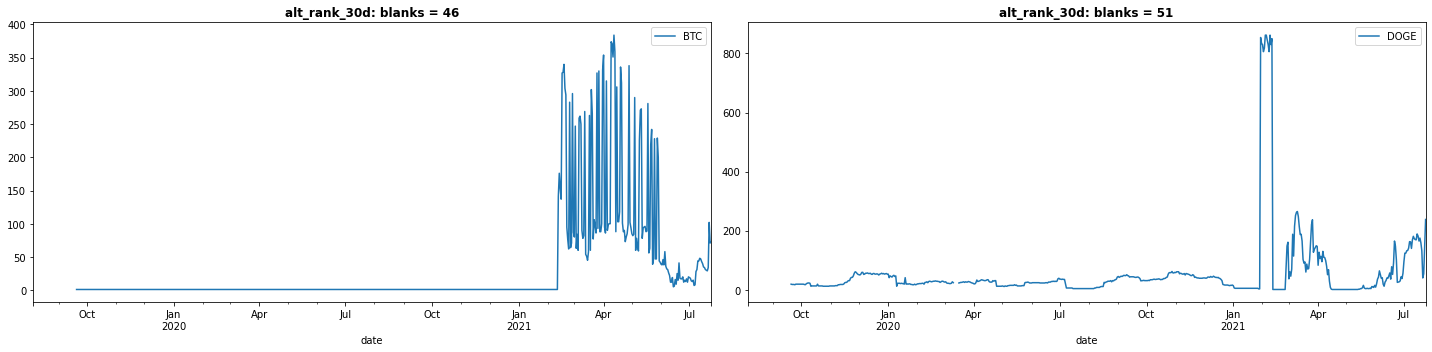

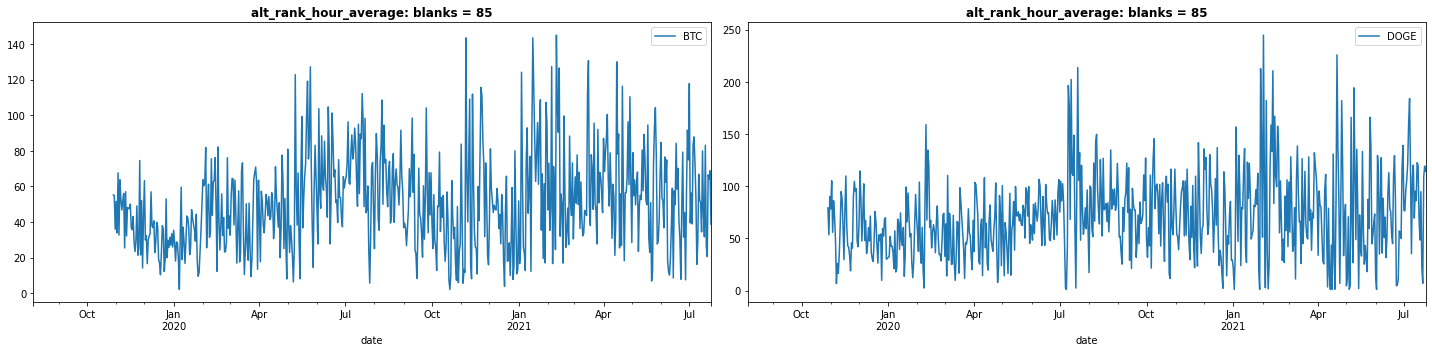

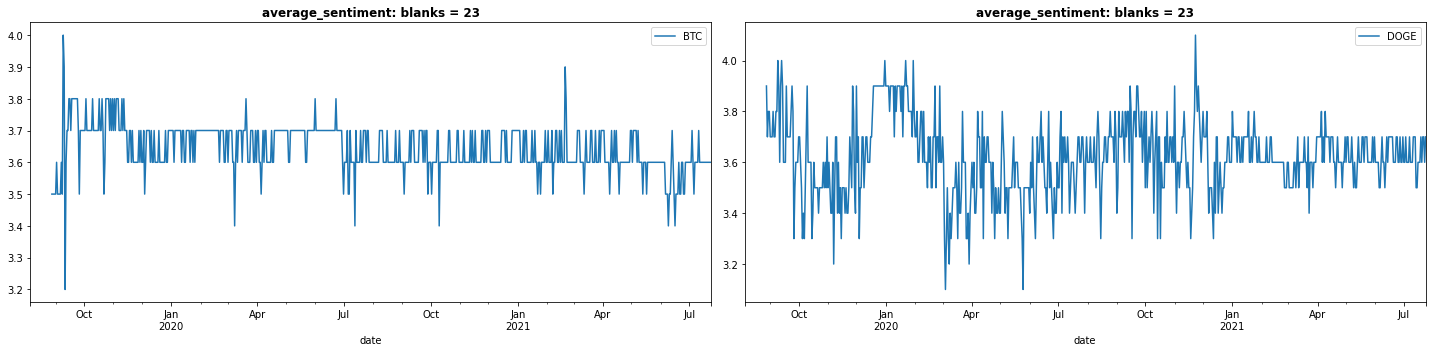

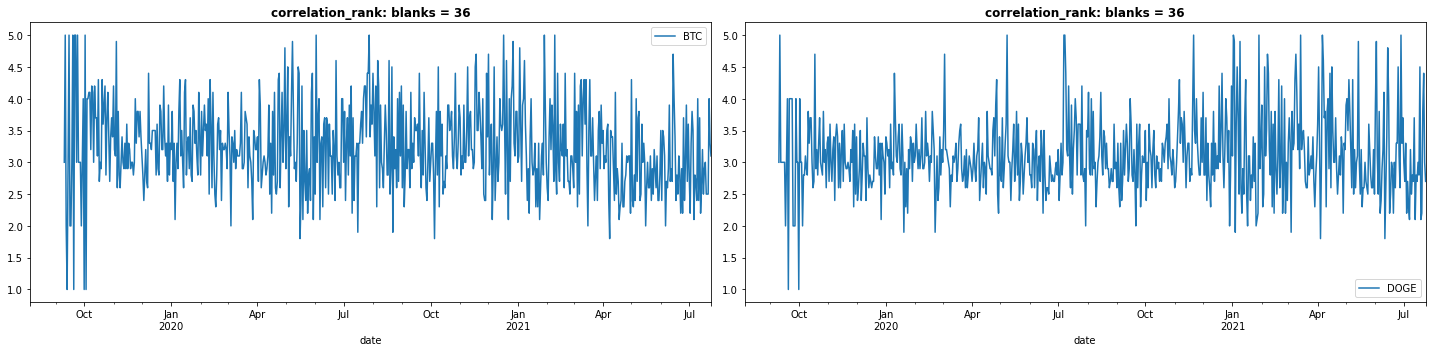

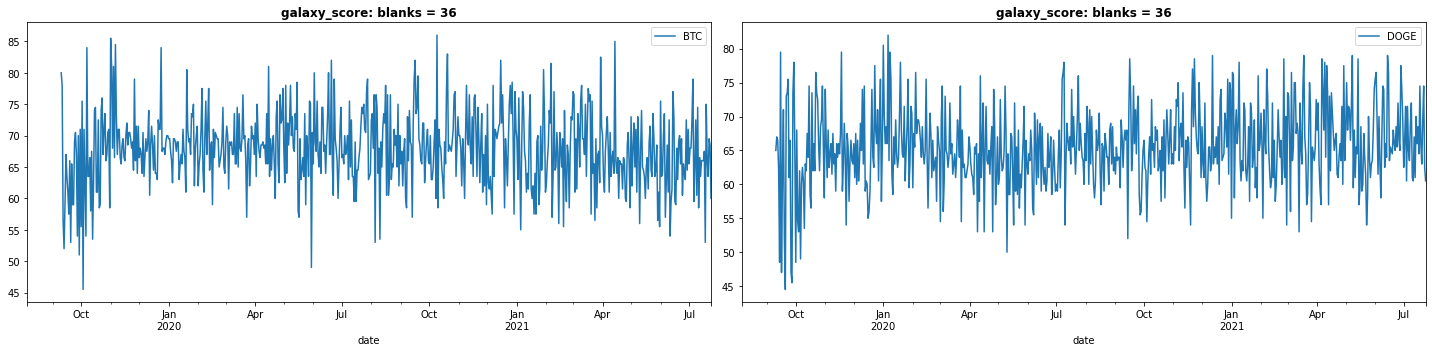

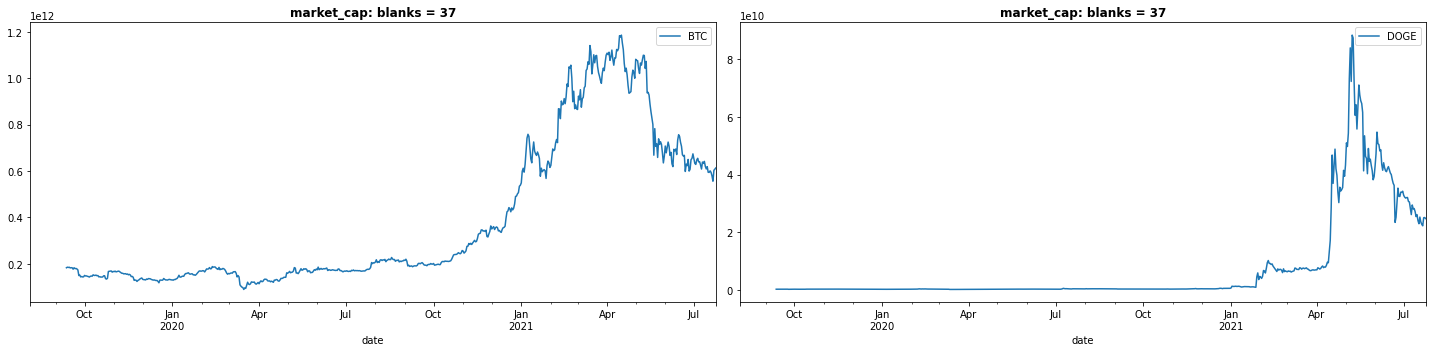

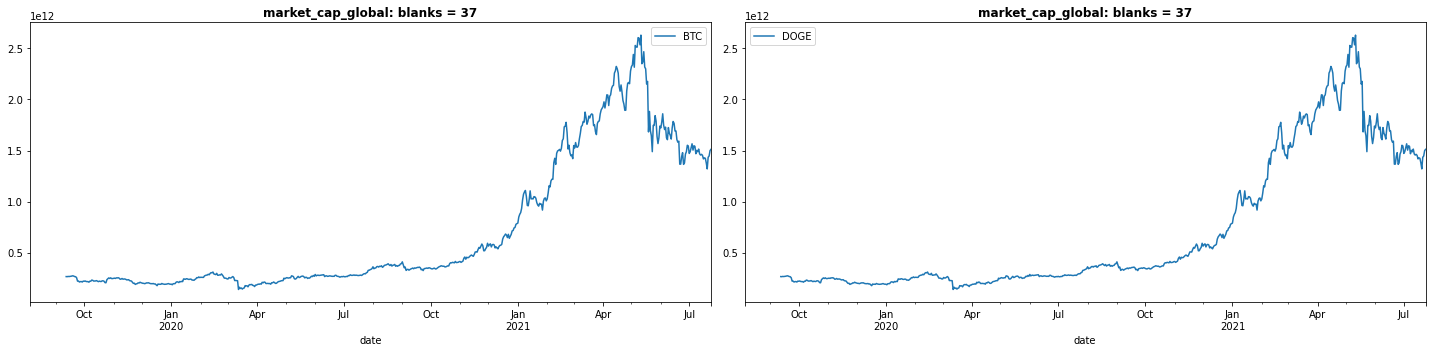

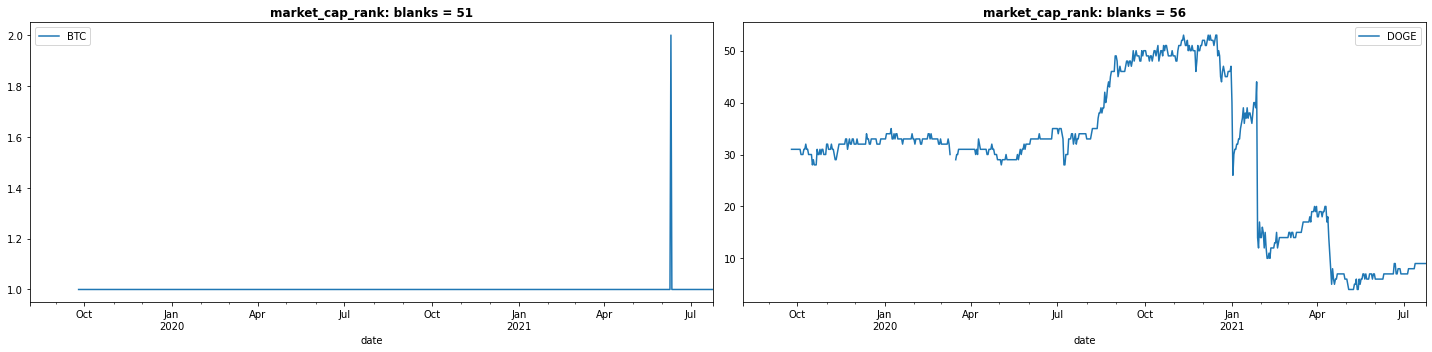

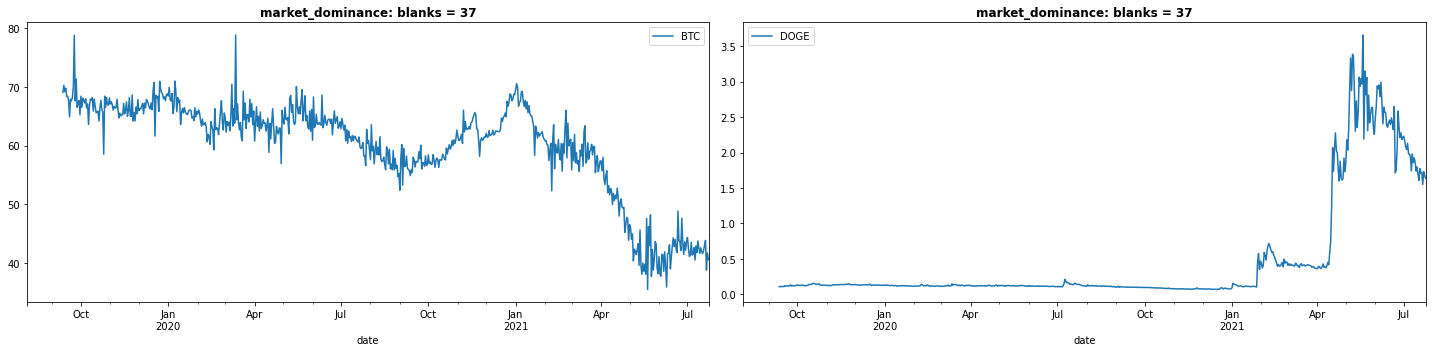

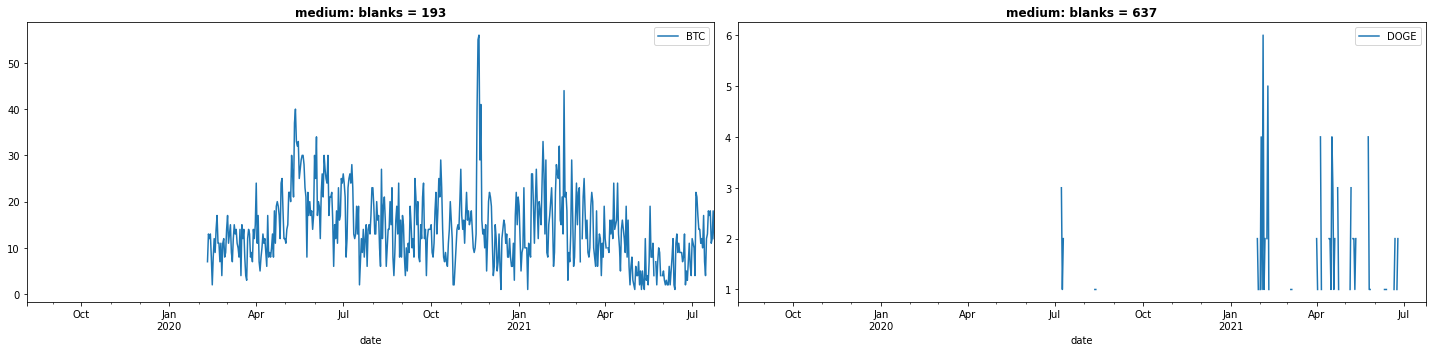

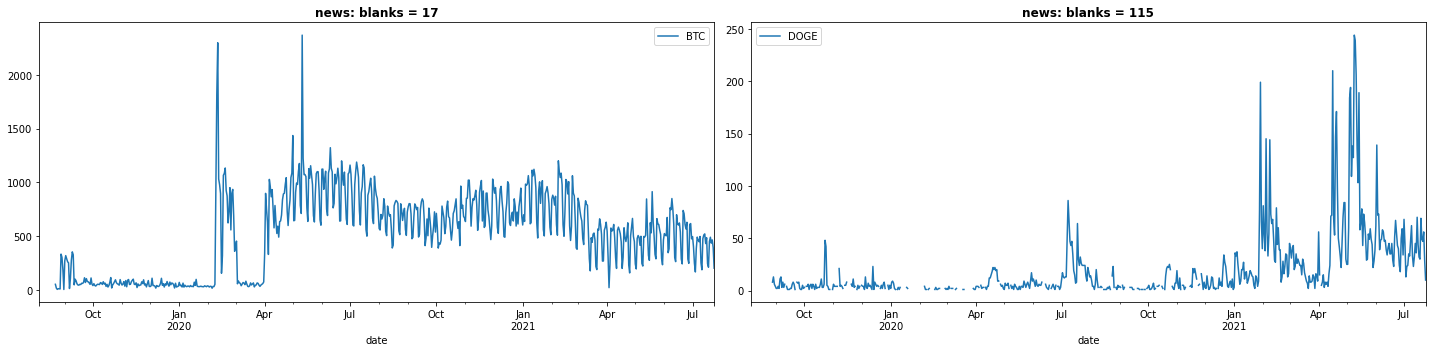

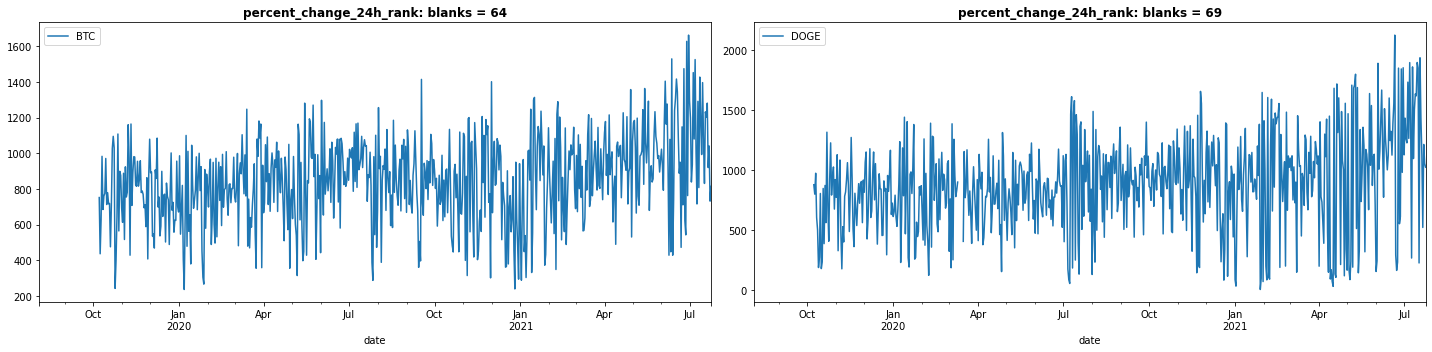

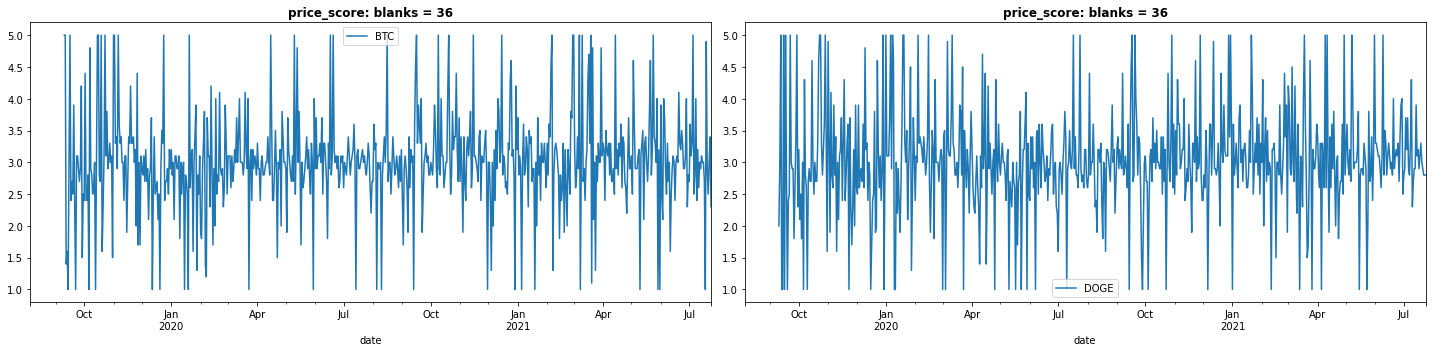

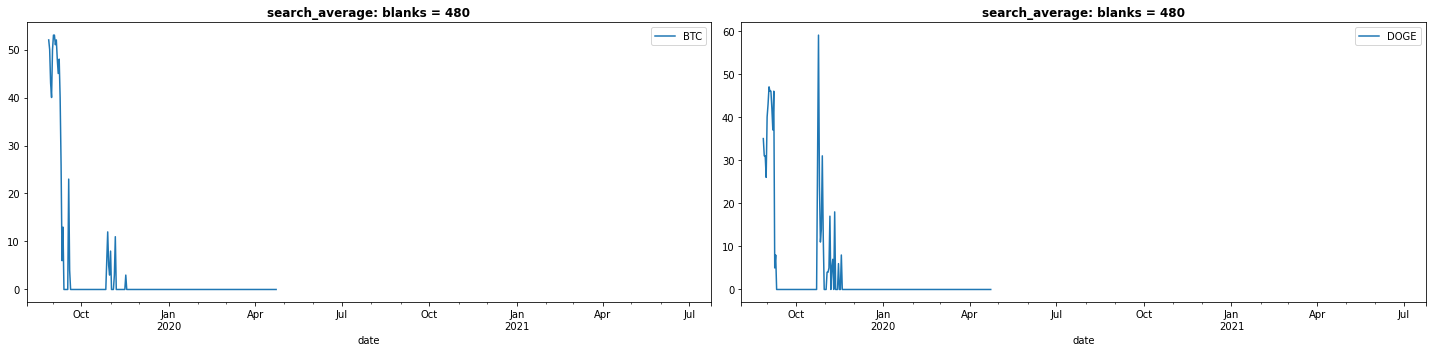

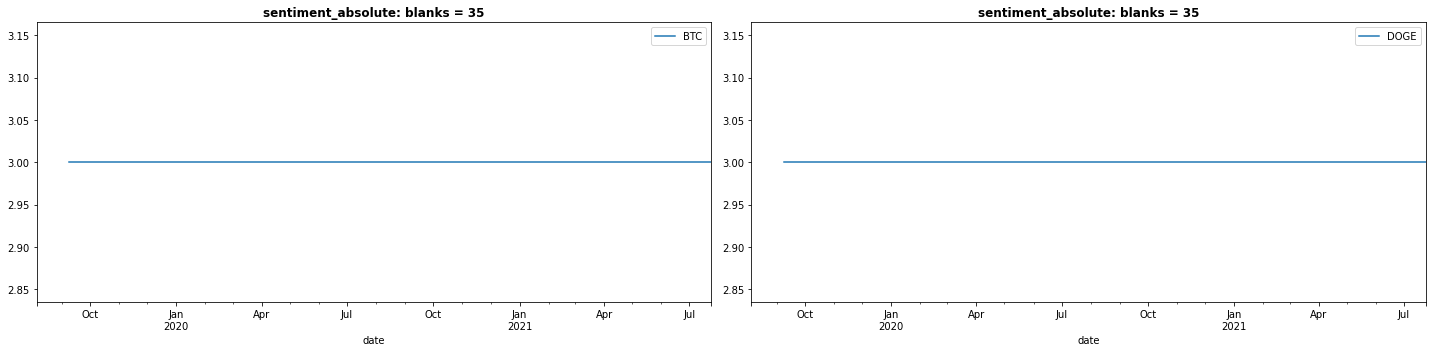

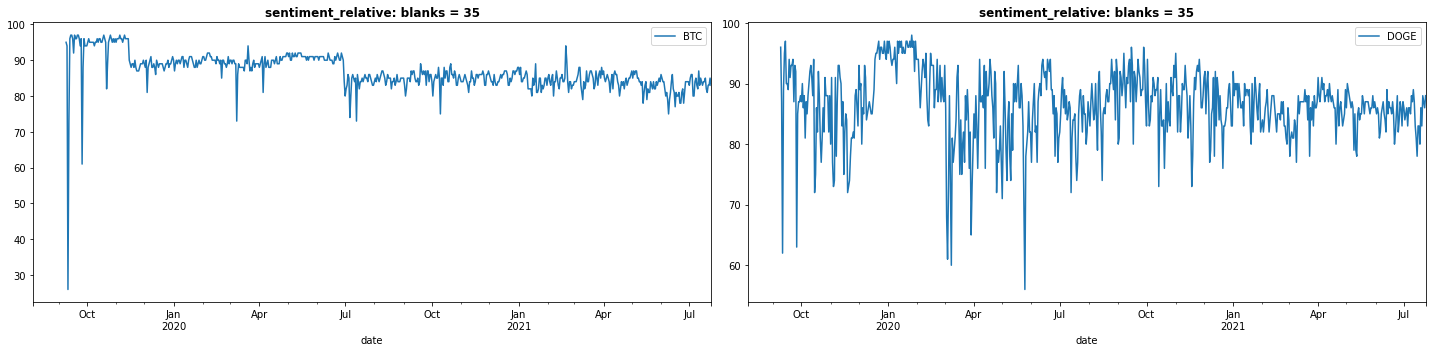

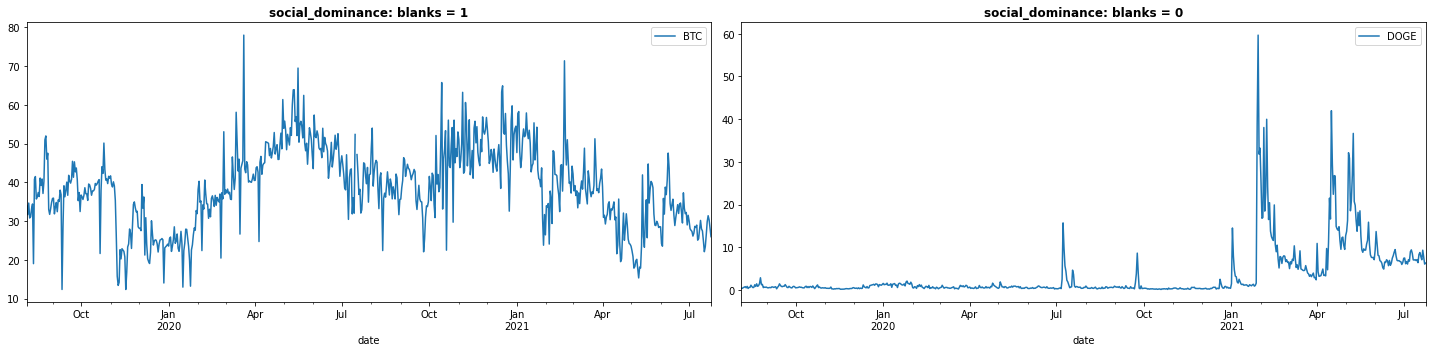

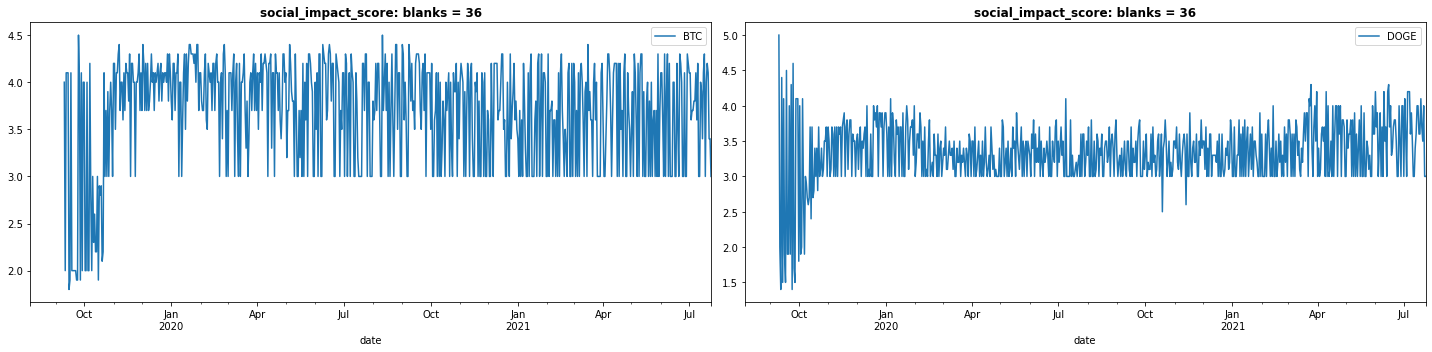

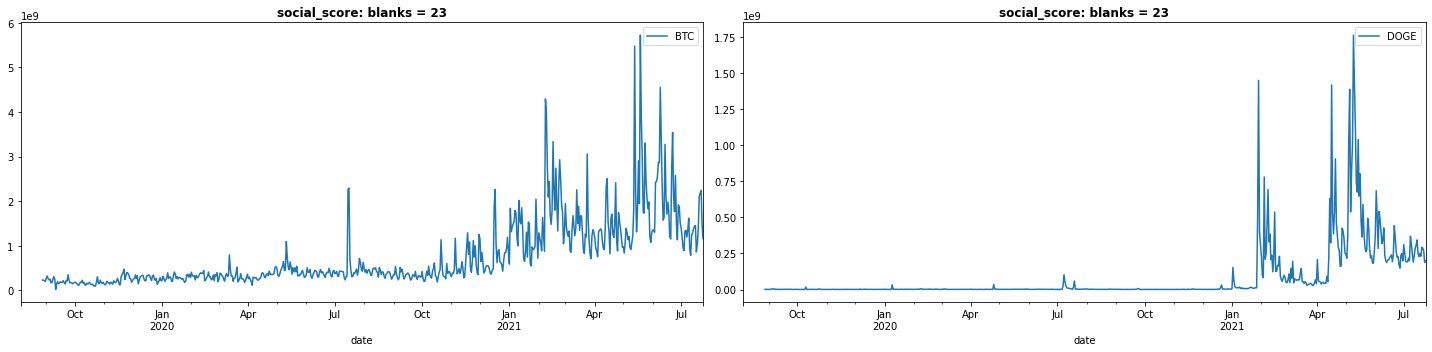

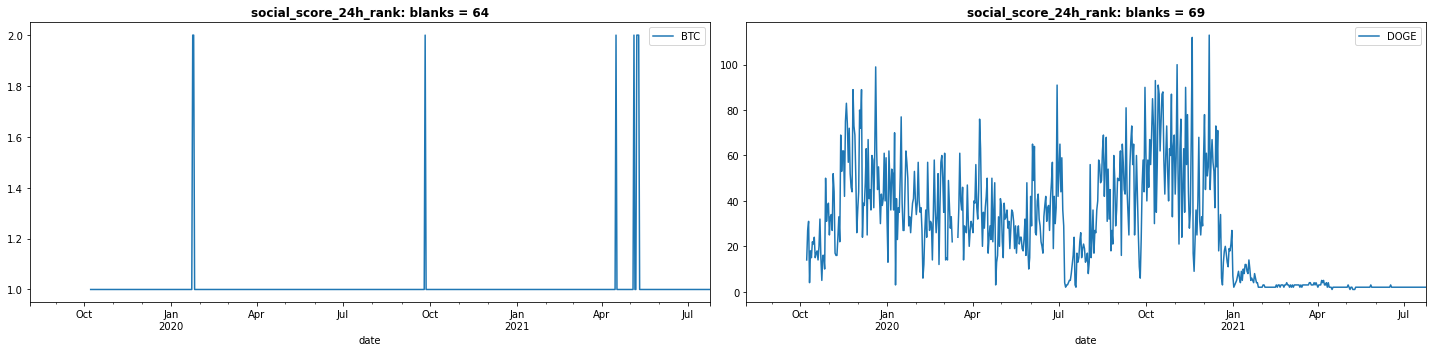

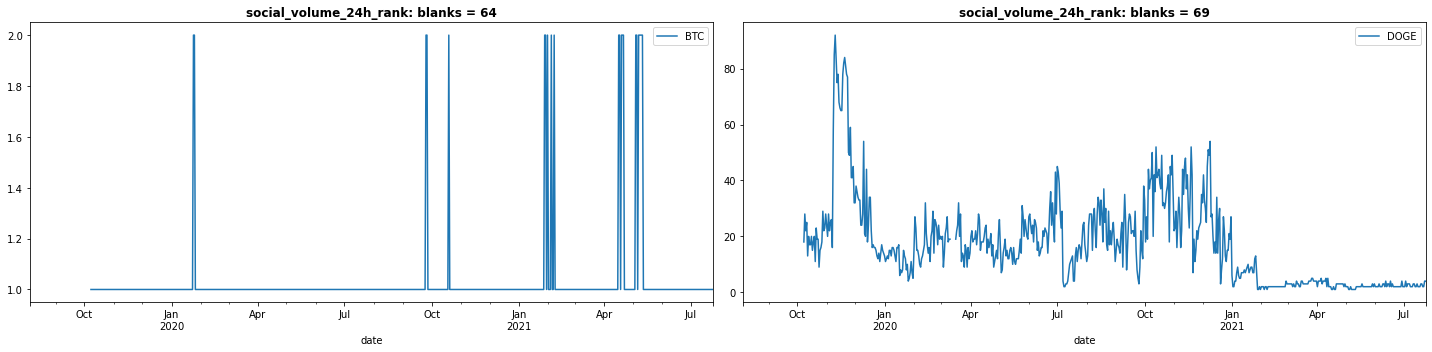

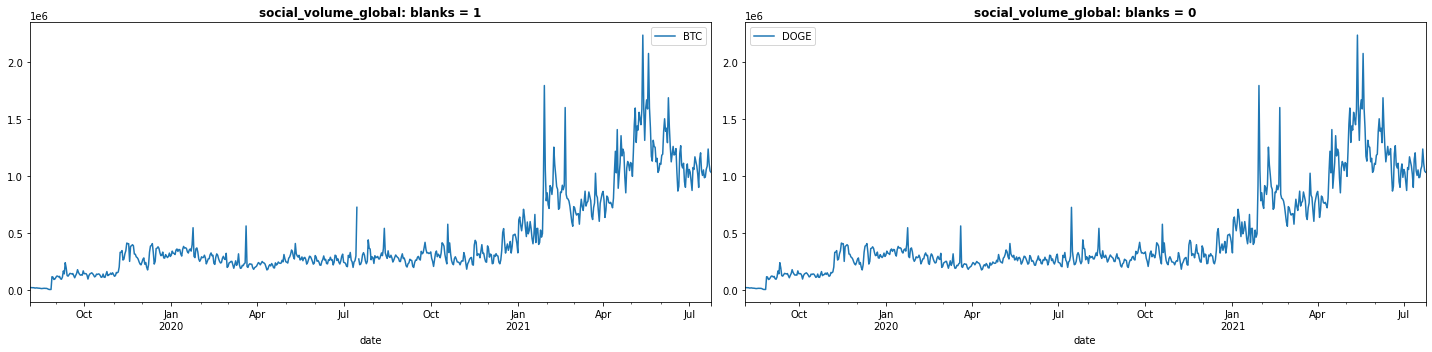

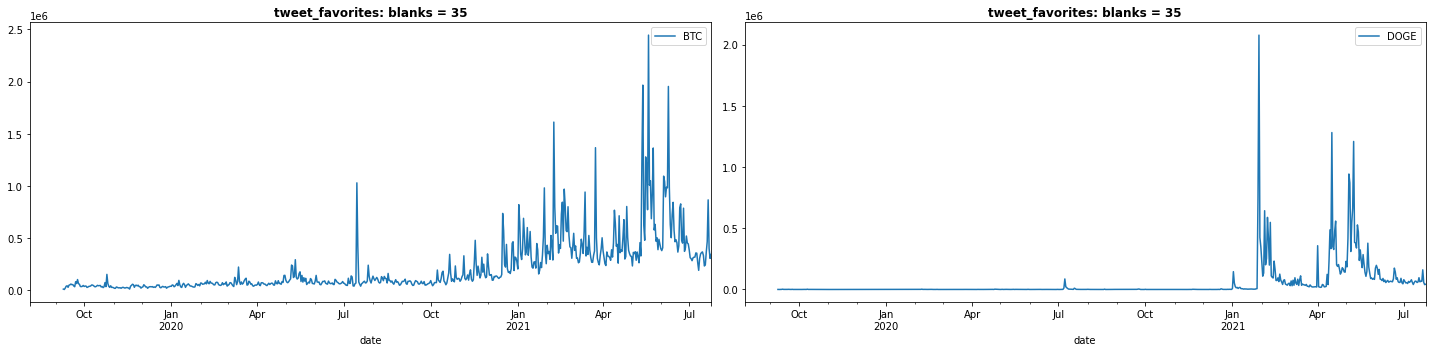

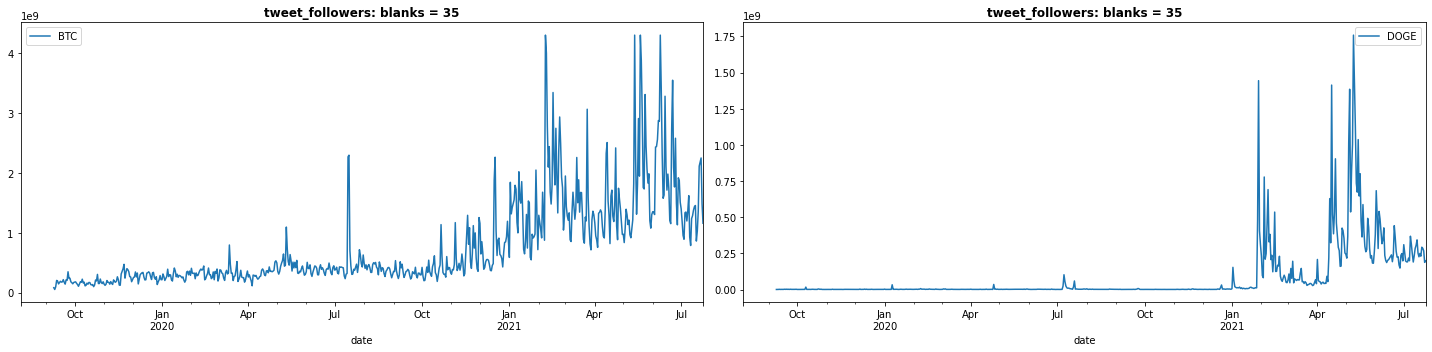

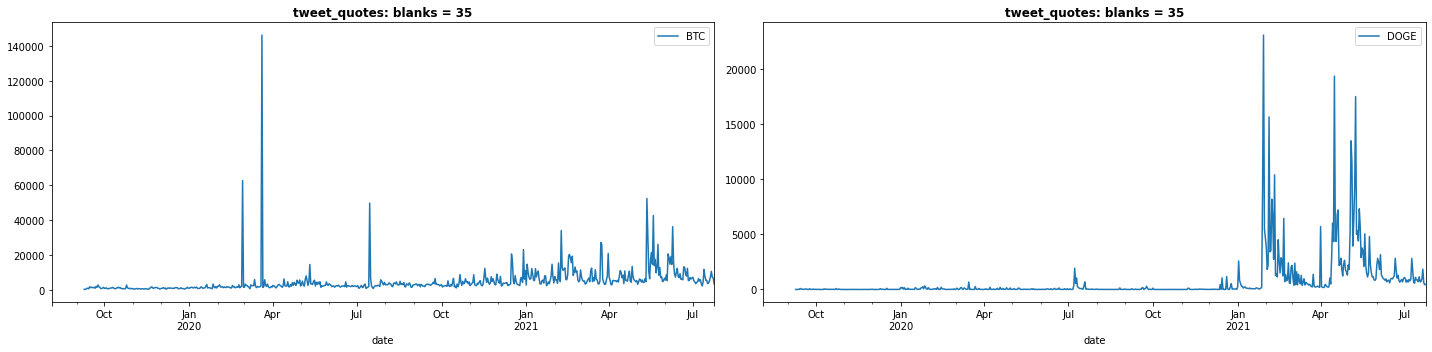

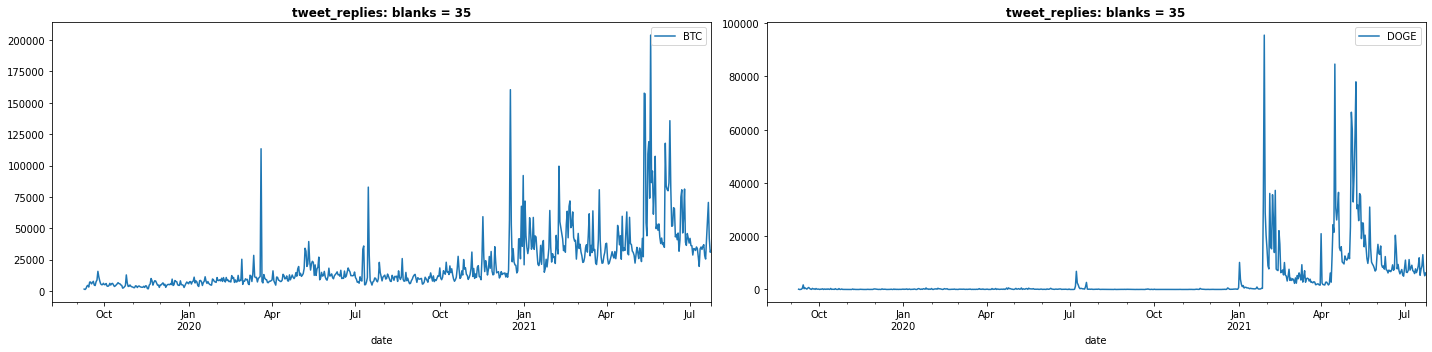

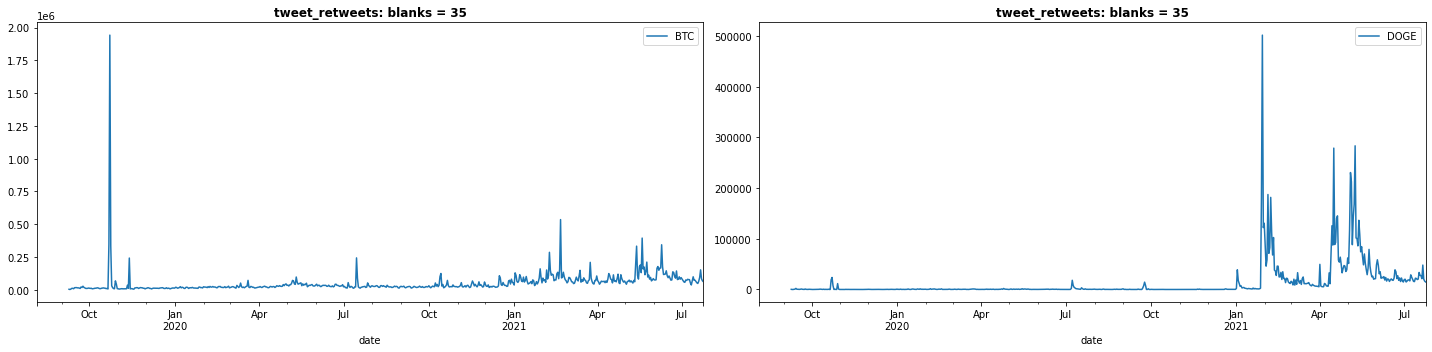

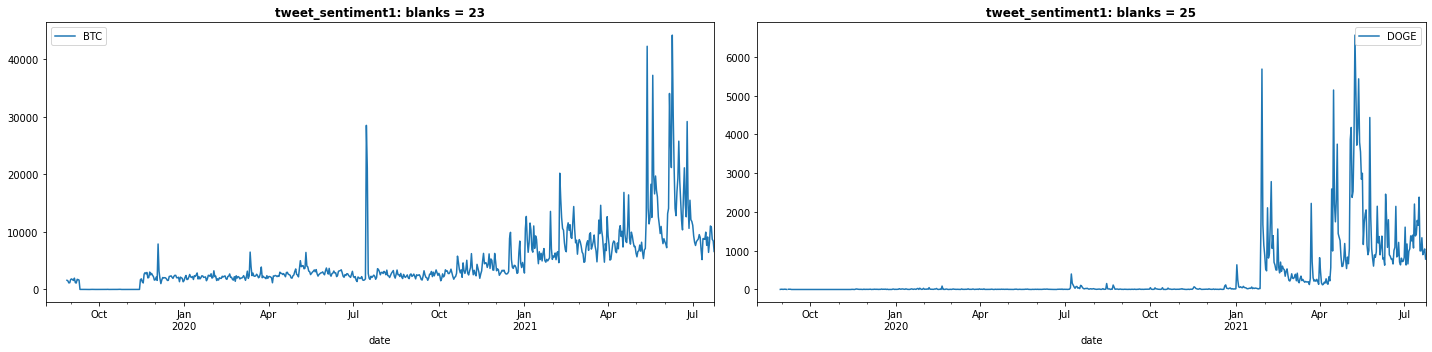

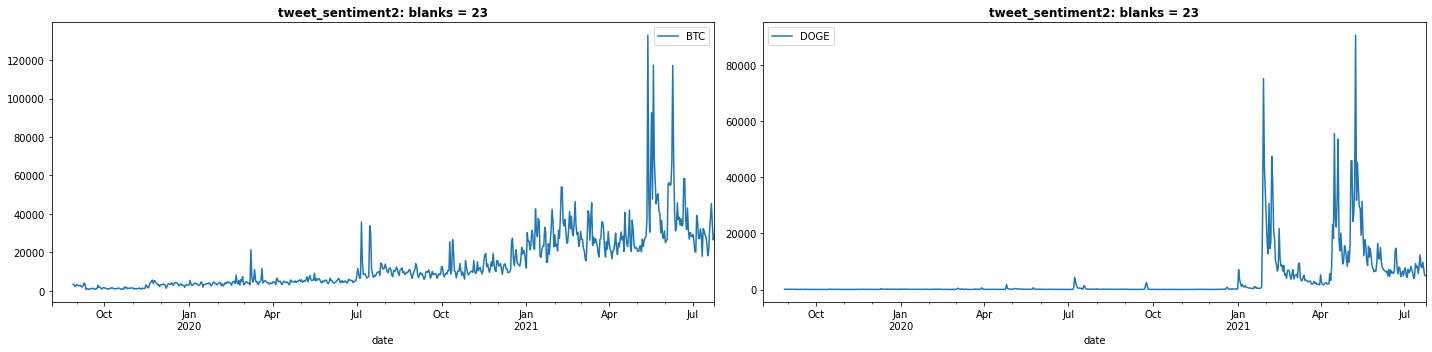

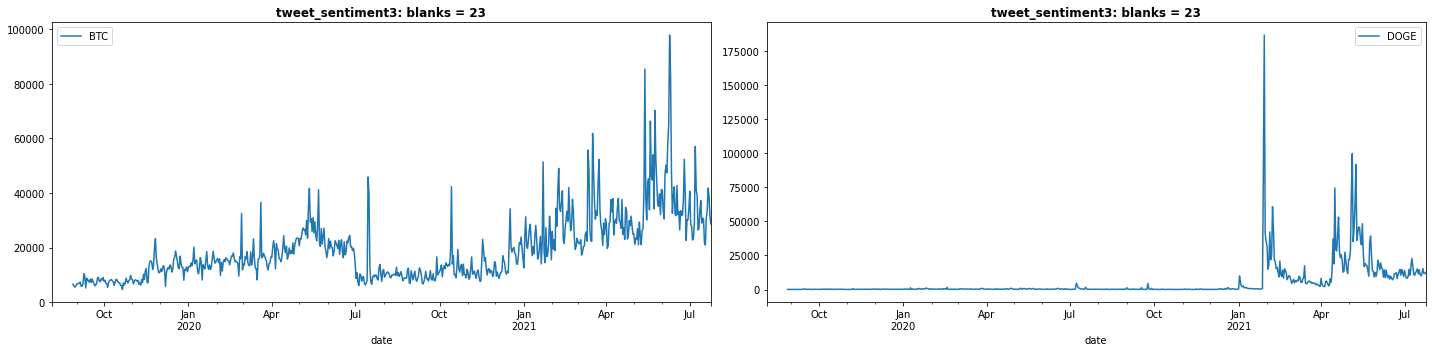

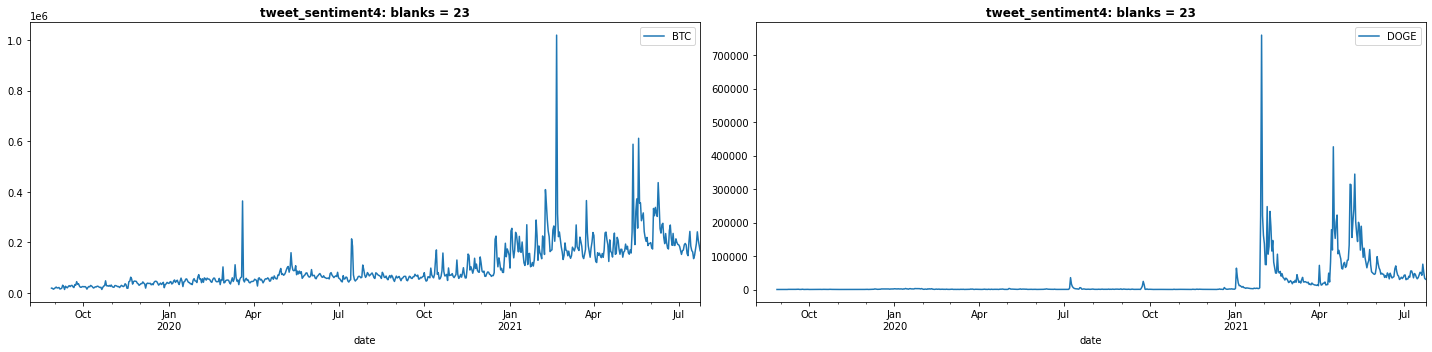

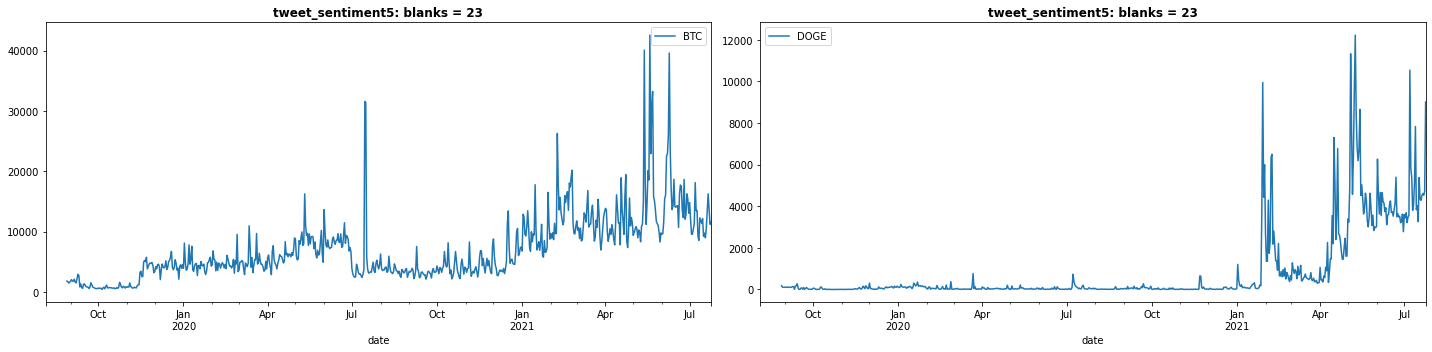

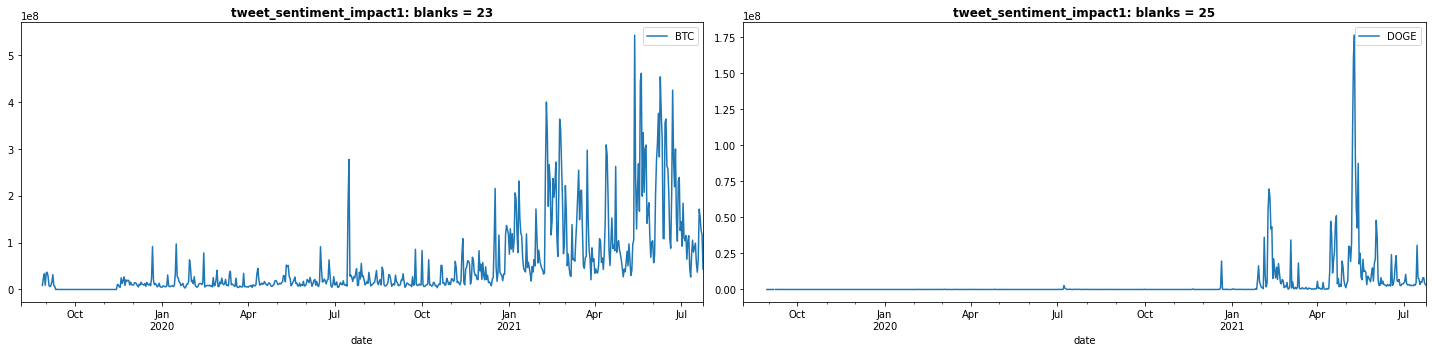

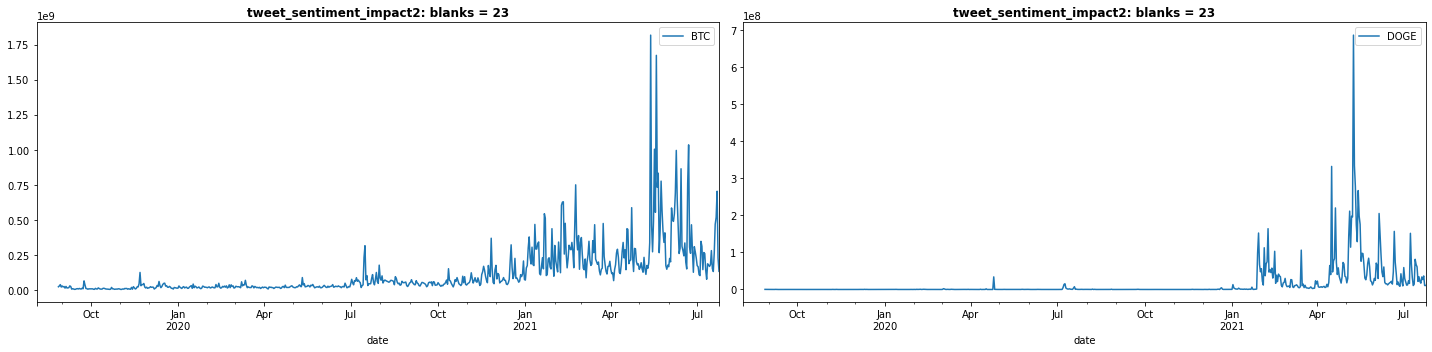

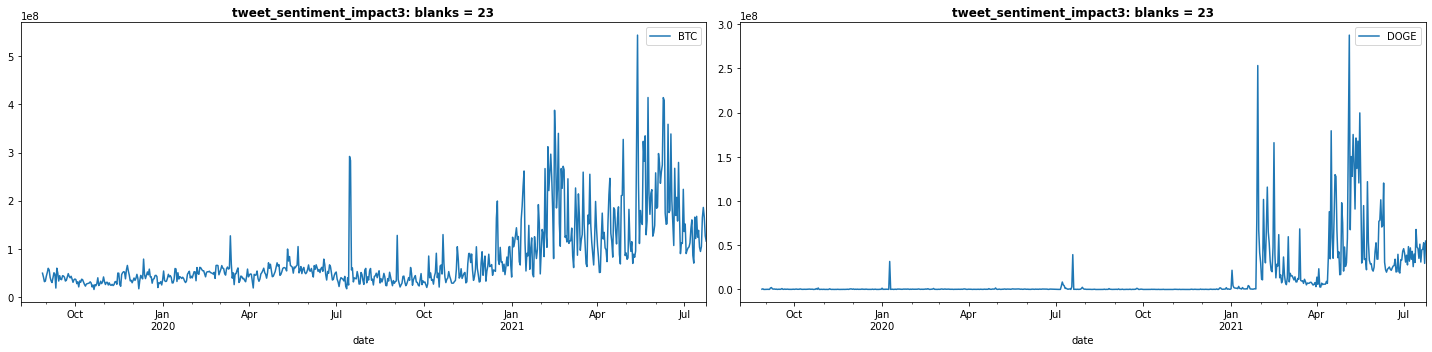

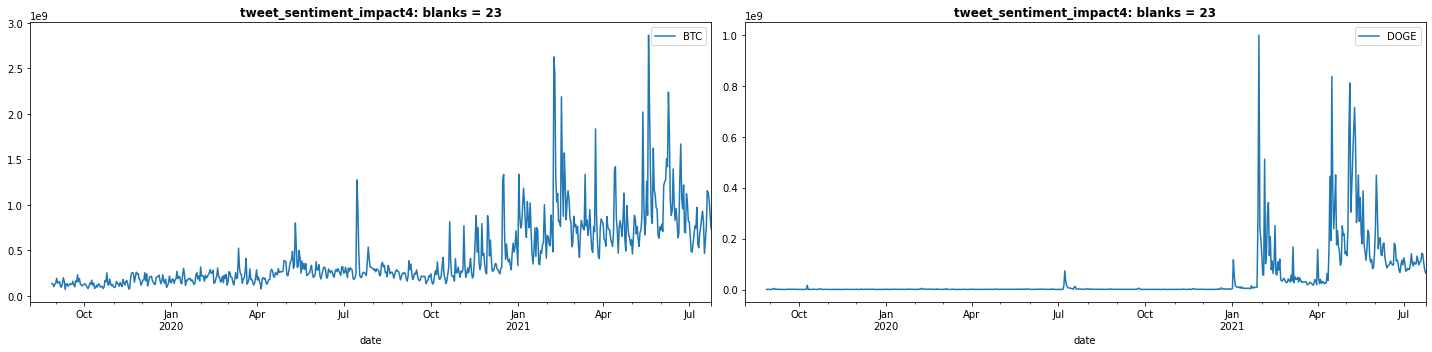

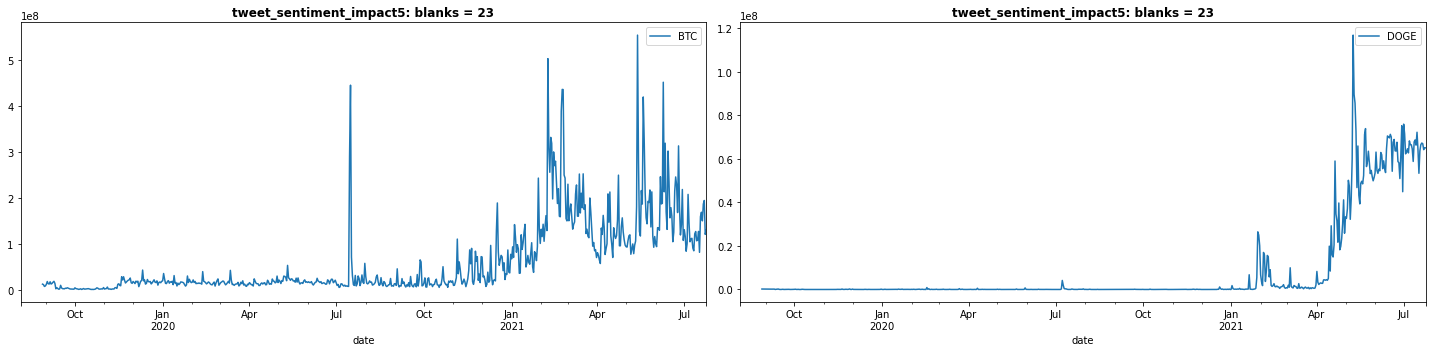

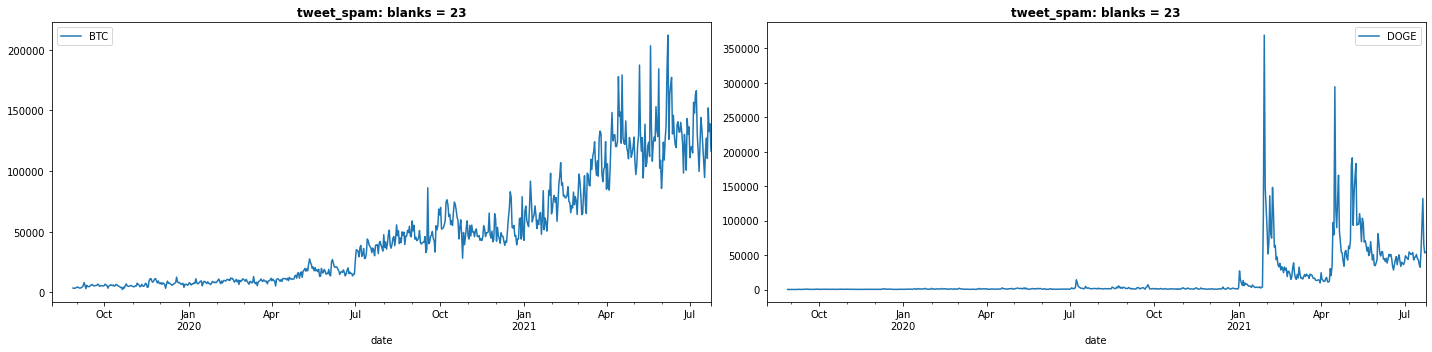

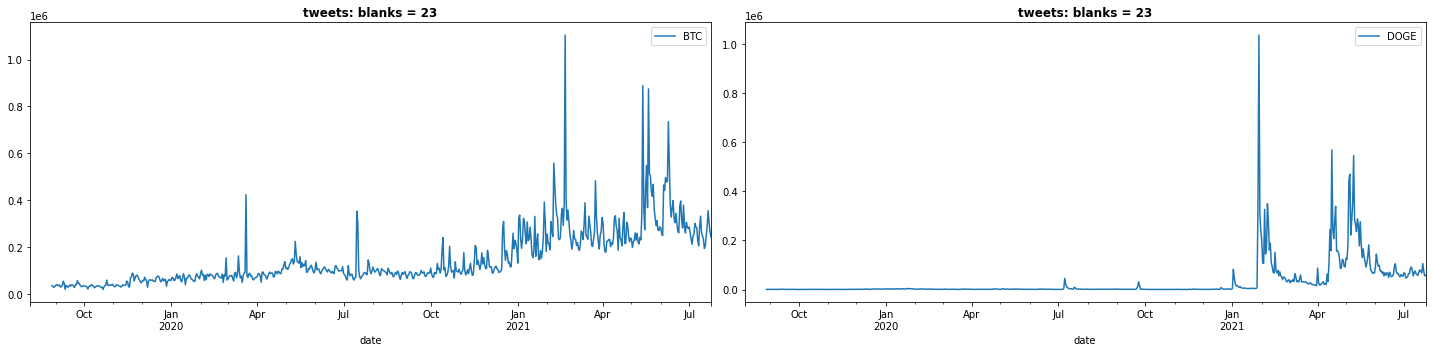

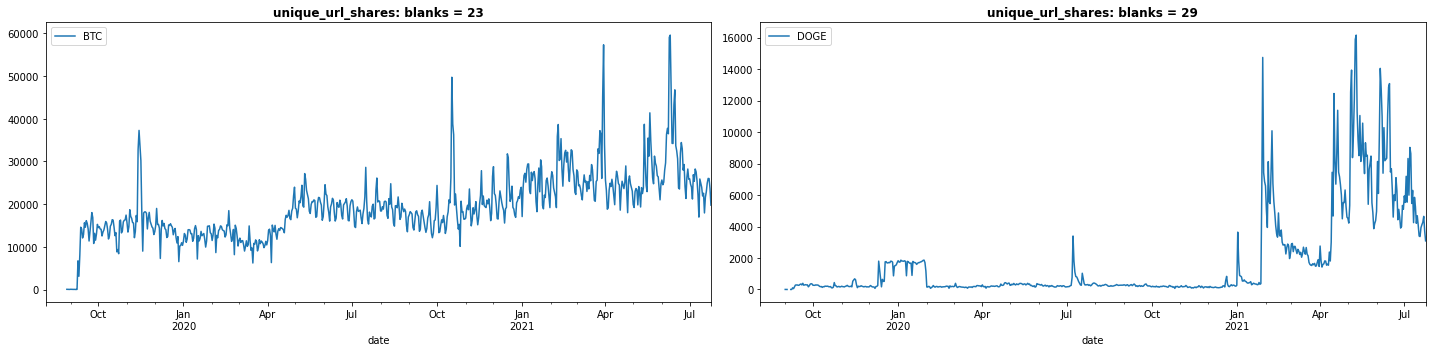

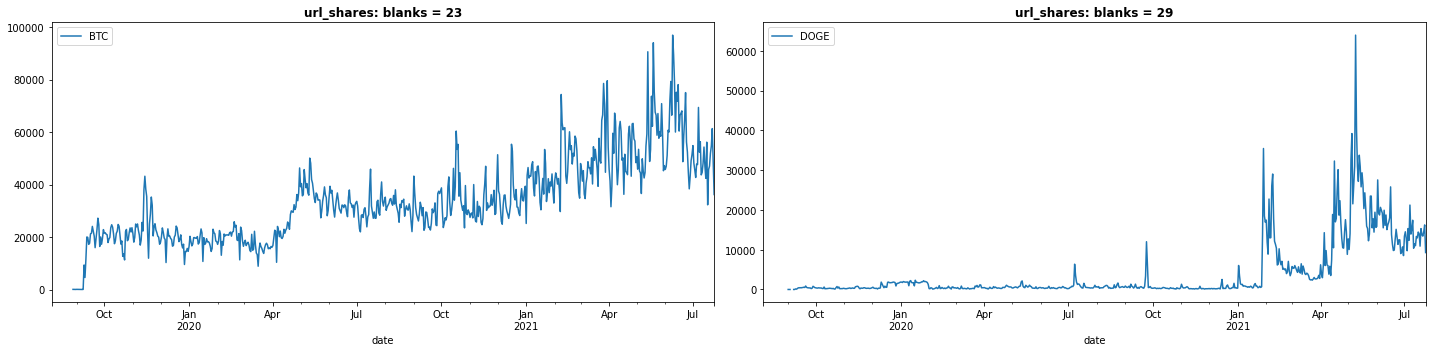

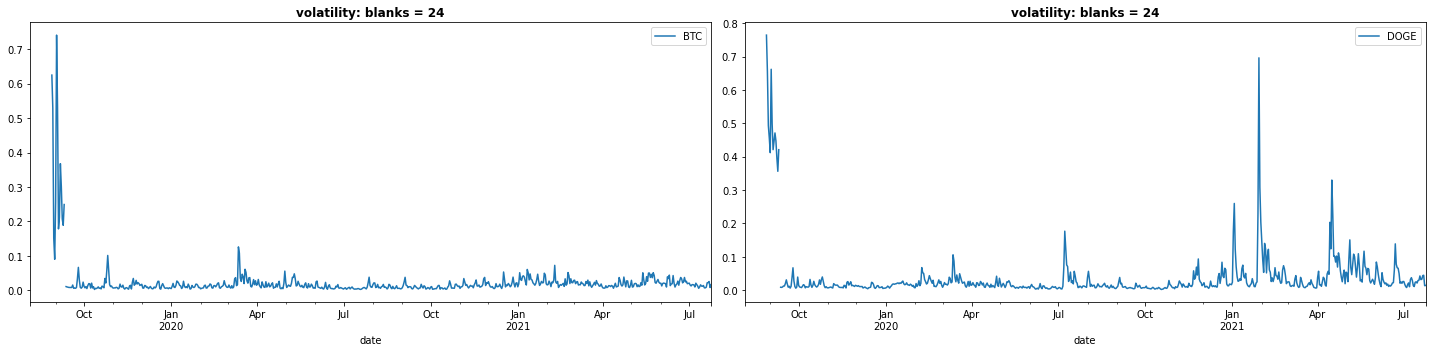

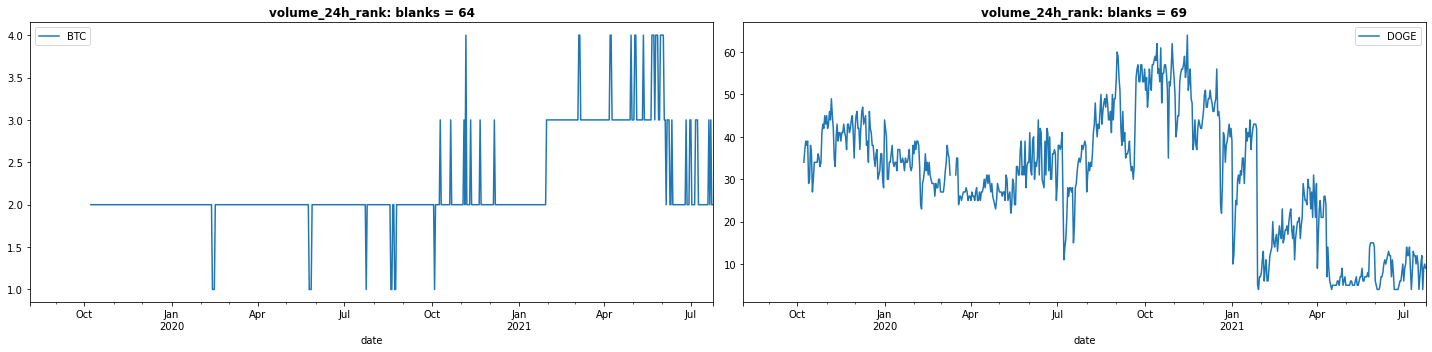

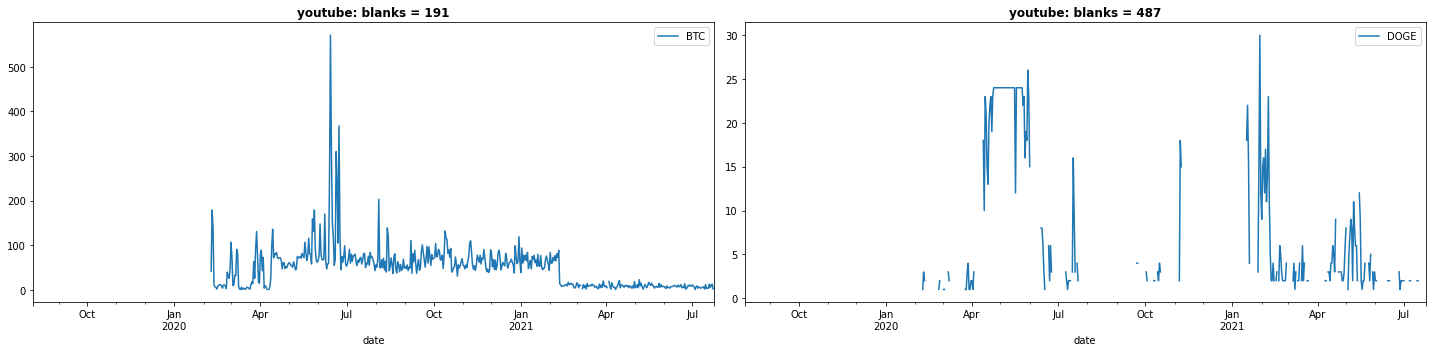

In [10]:
for col in sorted(blanks_set):
    fig, axes = plt.subplots(1,len(coins), figsize=(20,5))
    for i, coin in enumerate(coins):
        blanks = str(dfs[coin][col].isna().sum())
        ax = axes[i]
        dfs[coin][col].plot(ax=ax, label=coin)
        ax.set_title(col + ": blanks = " + blanks, fontweight='bold', size=12)
        ax.legend()
    plt.tight_layout()
    plt.show()

Most of the metrics are either missing data at the beginning of the time series or have a gap of 27-41 days in the Aug 2019 - Oct 2019 timeframe.

`medium` metric appears to be newer that started in Feb 2020 and also has intermittent blanks for DOGE.  This could be that DOGE was not as popular until recent.  Replace with zero but in the modeling staging may need to just exclude these 2 metrics.

`news` for DOGE has intermittent missing values so will replace with zero.

`search_average` metric appears to have been removed and is not populated after May 2020 so this column will be dropped.

`sentiment_absolute` metric is 3 for all coins so this column will be dropped.

`social_dominance` metric appears to no longer being populated with zeroes from Aug 2019.

`youtube` metric also appears to be newer that started in Feb 2020 so this may have been added with `medium`.

## 1.3 Data Cleaning

In [11]:
# Go back to November 2019 to include most social media metrics
btc = dfs['BTC'][dfs['BTC'].index >= '2019-11-01'].copy()

drop_cols = ['alt_rank_hour_average', 'search_average', 'sentiment_absolute', 'social_dominance']

btc = btc.drop(drop_cols, axis=1, errors='ignore')

zero_cols = ['medium', 'news', 'youtube']

btc[zero_cols] = btc[zero_cols].fillna(0)

btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 632 entries, 2019-11-01 to 2021-07-24
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 632 non-null    int64  
 1   time                     632 non-null    int64  
 2   open                     632 non-null    float64
 3   close                    632 non-null    float64
 4   high                     632 non-null    float64
 5   low                      632 non-null    float64
 6   volume                   632 non-null    float64
 7   market_cap               632 non-null    float64
 8   url_shares               632 non-null    float64
 9   unique_url_shares        632 non-null    float64
 10  reddit_posts             632 non-null    int64  
 11  reddit_posts_score       632 non-null    int64  
 12  reddit_comments          632 non-null    int64  
 13  reddit_comments_score    632 non-null    int64  
 14  tweets 

`social_volume_global` is only missing 1 value so will interpolate the gap in the time series.

In [12]:
# Interpolate the 1 missing blank for social_volume_global
btc['social_volume_global'] = btc['social_volume_global'].interpolate().round()

In [13]:
btc.isna().sum()

asset_id                   0
time                       0
open                       0
close                      0
high                       0
low                        0
volume                     0
market_cap                 0
url_shares                 0
unique_url_shares          0
reddit_posts               0
reddit_posts_score         0
reddit_comments            0
reddit_comments_score      0
tweets                     0
tweet_spam                 0
tweet_followers            0
tweet_quotes               0
tweet_retweets             0
tweet_replies              0
tweet_favorites            0
tweet_sentiment1           0
tweet_sentiment2           0
tweet_sentiment3           0
tweet_sentiment4           0
tweet_sentiment5           0
tweet_sentiment_impact1    0
tweet_sentiment_impact2    0
tweet_sentiment_impact3    0
tweet_sentiment_impact4    0
tweet_sentiment_impact5    0
social_score               0
average_sentiment          0
sentiment_relative         0
news          

No missing values for BTC.

In [14]:
# Go back to November 2019 to include most social media metrics
doge = dfs['DOGE'][dfs['DOGE'].index >= '2019-11-01'].copy()

doge = doge.drop(drop_cols, axis=1, errors='ignore')

doge[zero_cols] = doge[zero_cols].fillna(0)

doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 632 entries, 2019-11-01 to 2021-07-24
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 632 non-null    int64  
 1   time                     632 non-null    int64  
 2   open                     632 non-null    float64
 3   close                    632 non-null    float64
 4   high                     632 non-null    float64
 5   low                      632 non-null    float64
 6   volume                   632 non-null    float64
 7   market_cap               632 non-null    float64
 8   url_shares               632 non-null    float64
 9   unique_url_shares        632 non-null    float64
 10  reddit_posts             632 non-null    int64  
 11  reddit_posts_score       632 non-null    int64  
 12  reddit_comments          632 non-null    int64  
 13  reddit_comments_score    632 non-null    int64  
 14  tweets 

The rank columns have 5 missing values so let's explore that more closely.

In [15]:
rank_cols = ['alt_rank','alt_rank_30d','market_cap_rank','percent_change_24h_rank',
             'volume_24h_rank','social_volume_24h_rank', 'social_score_24h_rank']

doge[doge[rank_cols].isna().any(axis=1)]

asset_id        time      open     close      high       low  \
date                                                                       
2020-03-11        29  1583884800  0.002148  0.002221  0.002298  0.002143   
2020-03-12        29  1583971200  0.001367  0.001530  0.001581  0.001317   
2020-03-13        29  1584057600  0.001792  0.001780  0.001892  0.001656   
2020-03-14        29  1584144000  0.001663  0.001667  0.001716  0.001615   
2020-03-15        29  1584230400  0.001718  0.001671  0.001771  0.001618   

                 volume   market_cap  url_shares  unique_url_shares  ...  \
date                                                                 ...   
2020-03-11   70343744.0  270993593.0       250.0              145.0  ...   
2020-03-12  109765283.0  208024408.0       191.0              143.0  ...   
2020-03-13  158515449.0  206310014.0       158.0              122.0  ...   
2020-03-14   76827508.0  212119965.0       413.0              149.0  ...   
2020-03-15   83613513.0  212351008.0       254.0              132.0  ...   

            youtube  social_contributors  social_volume     price_btc  \
date                                                                    
2020-03-11      0.0                  879            874  2.790754e-07   
2020-03-12      0.0                  711           1293  3.103532e-07   
2020-03-13      0.0                 1042           1084  3.106498e-07   
2020-03-14      1.0                  865           1147  3.190493e-07   
2020-03-15      0.0                  867           1381  3.105080e-07   

            social_volume_global  percent_change_24h  market_cap_global  \
date                                                                      
2020-03-11                236169           -0.358905       2.247385e+11   
2020-03-12                315800          -31.112112       1.389236e+11   
2020-03-13                217481           16.339869       1.612990e+11   
2020-03-14                188433           -6.348315       1.486319e+11   
2020-03-15                191585            0.239952       1.535616e+11   

            market_dominance      name  symbol  
date                                            
2020-03-11          0.120582  Dogecoin    DOGE  
2020-03-12          0.149740  Dogecoin    DOGE  
2020-03-13          0.127905  Dogecoin    DOGE  
2020-03-14          0.142715  Dogecoin    DOGE  
2020-03-15          0.138284  Dogecoin    DOGE  

[5 rows x 58 columns]

The timeframe is sort of random from 3/11/20 - 3/15/20.

In [16]:
doge[rank_cols][doge.index >= '2020-03-01'].head(20)

alt_rank  alt_rank_30d  market_cap_rank  percent_change_24h_rank  \
date                                                                           
2020-03-01      10.0          26.0             32.0                    323.0   
2020-03-02      82.0          27.0             32.0                    760.0   
2020-03-03       4.0          23.0             32.0                    186.0   
2020-03-04     189.0          22.0             32.0                   1386.0   
2020-03-05       4.0          22.0             32.0                    252.0   
2020-03-06     154.0          21.0             32.0                   1257.0   
2020-03-07      52.0          21.0             32.0                    955.0   
2020-03-08      12.0          22.0             33.0                    779.0   
2020-03-09      53.0          27.0             32.0                    831.0   
2020-03-10      24.0          24.0             30.0                    900.0   
2020-03-11       NaN           NaN              NaN                      NaN   
2020-03-12       NaN           NaN              NaN                      NaN   
2020-03-13       NaN           NaN              NaN                      NaN   
2020-03-14       NaN           NaN              NaN                      NaN   
2020-03-15       NaN           NaN              NaN                      NaN   
2020-03-16       2.0          23.0             29.0                    406.0   
2020-03-17     138.0          24.0             30.0                   1155.0   
2020-03-18      44.0          25.0             30.0                    770.0   
2020-03-19      89.0          25.0             31.0                    845.0   
2020-03-20      84.0          26.0             31.0                   1169.0   

            volume_24h_rank  social_volume_24h_rank  social_score_24h_rank  
date                                                                        
2020-03-01             27.0                    19.0                   35.0  
2020-03-02             27.0                    20.0                   61.0  
2020-03-03             27.0                     9.0                   14.0  
2020-03-04             29.0                    14.0                   15.0  
2020-03-05             32.0                    21.0                   14.0  
2020-03-06             34.0                    23.0                   49.0  
2020-03-07             38.0                    27.0                   38.0  
2020-03-08             36.0                    18.0                   28.0  
2020-03-09             35.0                    19.0                   33.0  
2020-03-10             31.0                    19.0                   22.0  
2020-03-11              NaN                     NaN                    NaN  
2020-03-12              NaN                     NaN                    NaN  
2020-03-13              NaN                     NaN                    NaN  
2020-03-14              NaN                     NaN                    NaN  
2020-03-15              NaN                     NaN                    NaN  
2020-03-16             31.0                    19.0                   24.0  
2020-03-17             35.0                    22.0                   37.0  
2020-03-18             35.0                    24.0                   61.0  
2020-03-19             24.0                    32.0                   40.0  
2020-03-20             26.0                    20.0                   36.0

For DOGE there could have been an issue with the rankings during this timeframe so will interpolate the gap in the time series.

In [17]:
# Interpolate the 1 missing blank for social_volume_global
doge[rank_cols] = doge[rank_cols].interpolate().round()

doge[rank_cols][doge.index >= '2020-03-01'].head(20)

alt_rank  alt_rank_30d  market_cap_rank  percent_change_24h_rank  \
date                                                                           
2020-03-01      10.0          26.0             32.0                    323.0   
2020-03-02      82.0          27.0             32.0                    760.0   
2020-03-03       4.0          23.0             32.0                    186.0   
2020-03-04     189.0          22.0             32.0                   1386.0   
2020-03-05       4.0          22.0             32.0                    252.0   
2020-03-06     154.0          21.0             32.0                   1257.0   
2020-03-07      52.0          21.0             32.0                    955.0   
2020-03-08      12.0          22.0             33.0                    779.0   
2020-03-09      53.0          27.0             32.0                    831.0   
2020-03-10      24.0          24.0             30.0                    900.0   
2020-03-11      20.0          24.0             30.0                    818.0   
2020-03-12      17.0          24.0             30.0                    735.0   
2020-03-13      13.0          24.0             30.0                    653.0   
2020-03-14       9.0          23.0             29.0                    571.0   
2020-03-15       6.0          23.0             29.0                    488.0   
2020-03-16       2.0          23.0             29.0                    406.0   
2020-03-17     138.0          24.0             30.0                   1155.0   
2020-03-18      44.0          25.0             30.0                    770.0   
2020-03-19      89.0          25.0             31.0                    845.0   
2020-03-20      84.0          26.0             31.0                   1169.0   

            volume_24h_rank  social_volume_24h_rank  social_score_24h_rank  
date                                                                        
2020-03-01             27.0                    19.0                   35.0  
2020-03-02             27.0                    20.0                   61.0  
2020-03-03             27.0                     9.0                   14.0  
2020-03-04             29.0                    14.0                   15.0  
2020-03-05             32.0                    21.0                   14.0  
2020-03-06             34.0                    23.0                   49.0  
2020-03-07             38.0                    27.0                   38.0  
2020-03-08             36.0                    18.0                   28.0  
2020-03-09             35.0                    19.0                   33.0  
2020-03-10             31.0                    19.0                   22.0  
2020-03-11             31.0                    19.0                   22.0  
2020-03-12             31.0                    19.0                   23.0  
2020-03-13             31.0                    19.0                   23.0  
2020-03-14             31.0                    19.0                   23.0  
2020-03-15             31.0                    19.0                   24.0  
2020-03-16             31.0                    19.0                   24.0  
2020-03-17             35.0                    22.0                   37.0  
2020-03-18             35.0                    24.0                   61.0  
2020-03-19             24.0                    32.0                   40.0  
2020-03-20             26.0                    20.0                   36.0

In [18]:
doge.isna().sum()

asset_id                   0
time                       0
open                       0
close                      0
high                       0
low                        0
volume                     0
market_cap                 0
url_shares                 0
unique_url_shares          0
reddit_posts               0
reddit_posts_score         0
reddit_comments            0
reddit_comments_score      0
tweets                     0
tweet_spam                 0
tweet_followers            0
tweet_quotes               0
tweet_retweets             0
tweet_replies              0
tweet_favorites            0
tweet_sentiment1           0
tweet_sentiment2           0
tweet_sentiment3           0
tweet_sentiment4           0
tweet_sentiment5           0
tweet_sentiment_impact1    0
tweet_sentiment_impact2    0
tweet_sentiment_impact3    0
tweet_sentiment_impact4    0
tweet_sentiment_impact5    0
social_score               0
average_sentiment          0
sentiment_relative         0
news          

No missing values for DOGE.

## 1.4 Buy/Hold/Sell Decision

For this project I'm going to build 2 different models:

1. Time Series modeling for price predictions for the next 7 days.
2. Multi-class classification model for a Buy, Hold or Sell recommendation over a 7 day window from the most recent closing price.

The buy/hold/sell decision logic is based on a forward looking window.

Buy:
1. Maximum gain during the window is > the desired threshold
2. Change in close price from the start to end of window is higher (window candle is green)
3. Lowest price during the window is >= the low price for the current day

Sell:
1. Maximum loss during the window is < the desired threshold
2. Change in close price from the start to end of window is lower (window candle is red)
3. Highest price during the window is <= the high price for the current day

All else the decision is Hold.

In [19]:
# Apply forward looking window metrics to data
btc = window_metrics(btc, 7, 1, .05)
doge = window_metrics(doge, 7, 1, .05)

In [20]:
btc[btc.isna().any(axis=1)]

asset_id        time          open         close          high  \
date                                                                         
2021-07-18         1  1626566400  31606.930797  31809.669288  32283.237454   
2021-07-19         1  1626652800  31786.788682  30875.739177  31796.302407   
2021-07-20         1  1626739200  30866.799428  29840.102572  30947.083841   
2021-07-21         1  1626825600  29844.754819  32157.744949  32811.312648   
2021-07-22         1  1626912000  32189.911089  32355.091848  32598.022446   
2021-07-23         1  1626998400  32329.932826  33647.021623  33647.021623   
2021-07-24         1  1627084800  33652.910832  33948.026444  34344.221410   

                     low        volume    market_cap  url_shares  \
date                                                               
2021-07-18  31248.619082  2.079459e+10  6.006819e+11     45711.0   
2021-07-19  30512.289255  2.371575e+10  5.941400e+11     47034.0   
2021-07-20  29459.897883  2.599444e+10  5.789197e+11     51938.0   
2021-07-21  29844.754819  3.423717e+10  5.560507e+11     54737.0   
2021-07-22  31918.472081  2.223158e+10  6.029536e+11     61315.0   
2021-07-23  32201.972102  2.560777e+10  6.078865e+11     48636.0   
2021-07-24  33471.497502  1.985106e+10  6.129809e+11     36204.0   

            unique_url_shares  ...  close_percent_change_1d  close_end_7d  \
date                           ...                                          
2021-07-18            21627.0  ...                -0.029360           NaN   
2021-07-19            22904.0  ...                -0.033542           NaN   
2021-07-20            24937.0  ...                 0.077669           NaN   
2021-07-21            26033.0  ...                 0.006137           NaN   
2021-07-22            25997.0  ...                 0.039930           NaN   
2021-07-23            23670.0  ...                 0.008946           NaN   
2021-07-24            19782.0  ...                      NaN           NaN   

            close_min_7d  close_max_7d  close_loss_7d  close_gain_7d  \
date                                                                   
2021-07-18  29459.897883   34344.22141      -0.073870       0.079679   
2021-07-19  29459.897883   34344.22141      -0.045856       0.112337   
2021-07-20  29459.897883   34344.22141      -0.012741       0.150942   
2021-07-21  29844.754819   34344.22141      -0.071926       0.067992   
2021-07-22  31918.472081   34344.22141      -0.013495       0.061478   
2021-07-23  32201.972102   34344.22141      -0.042947       0.020721   
2021-07-24  33471.497502   34344.22141      -0.014037       0.011671   

            close_change_7d  close_percent_change_7d  decision  color  
date                                                                   
2021-07-18              NaN                      NaN       NaN    NaN  
2021-07-19              NaN                      NaN       NaN    NaN  
2021-07-20              NaN                      NaN       NaN    NaN  
2021-07-21              NaN                      NaN       NaN    NaN  
2021-07-22              NaN                      NaN       NaN    NaN  
2021-07-23              NaN                      NaN       NaN    NaN  
2021-07-24              NaN                      NaN       NaN    NaN  

[7 rows x 69 columns]

Blanks are related to 7 day forward window for decision.  I will want to keep these rows for final predictions as well as the LSTM models that won't be based on the 7 day forward window.

In [21]:
# Select all rows except for the current day
today = date.today().strftime('%Y-%m-%d')
btc = btc[btc.index < today]
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 631 entries, 2019-11-01 to 2021-07-23
Data columns (total 69 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 631 non-null    int64  
 1   time                     631 non-null    int64  
 2   open                     631 non-null    float64
 3   close                    631 non-null    float64
 4   high                     631 non-null    float64
 5   low                      631 non-null    float64
 6   volume                   631 non-null    float64
 7   market_cap               631 non-null    float64
 8   url_shares               631 non-null    float64
 9   unique_url_shares        631 non-null    float64
 10  reddit_posts             631 non-null    int64  
 11  reddit_posts_score       631 non-null    int64  
 12  reddit_comments          631 non-null    int64  
 13  reddit_comments_score    631 non-null    int64  
 14  tweets 

In [22]:
doge[doge.isna().any(axis=1)]

asset_id        time      open     close      high       low  \
date                                                                       
2021-07-18        29  1626566400  0.188461  0.183223  0.197545  0.181598   
2021-07-19        29  1626652800  0.182591  0.175126  0.185222  0.172033   
2021-07-20        29  1626739200  0.175010  0.171616  0.181069  0.160800   
2021-07-21        29  1626825600  0.171802  0.191642  0.215289  0.169961   
2021-07-22        29  1626912000  0.192190  0.192400  0.198832  0.187651   
2021-07-23        29  1626998400  0.192171  0.195217  0.200698  0.184514   
2021-07-24        29  1627084800  0.195018  0.194375  0.203081  0.191315   

                  volume    market_cap  url_shares  unique_url_shares  ...  \
date                                                                   ...   
2021-07-18  1.877046e+09  2.526170e+10     10901.0             3361.0  ...   
2021-07-19  1.326751e+09  2.358565e+10     15308.0             3928.0  ...   
2021-07-20  2.246079e+09  2.271672e+10     13784.0             4115.0  ...   
2021-07-21  5.308045e+09  2.224167e+10     13424.0             4270.0  ...   
2021-07-22  2.055268e+09  2.503451e+10     14537.0             4645.0  ...   
2021-07-23  1.707028e+09  2.511383e+10     16242.0             3720.0  ...   
2021-07-24  1.378664e+09  2.475502e+10      9284.0             3088.0  ...   

            close_percent_change_1d  close_end_7d  close_min_7d  close_max_7d  \
date                                                                            
2021-07-18                -0.044195           NaN      0.160800      0.215289   
2021-07-19                -0.020038           NaN      0.160800      0.215289   
2021-07-20                 0.116685           NaN      0.160800      0.215289   
2021-07-21                 0.003959           NaN      0.169961      0.215289   
2021-07-22                 0.014641           NaN      0.184514      0.203081   
2021-07-23                -0.004313           NaN      0.184514      0.203081   
2021-07-24                      NaN           NaN      0.191315      0.203081   

            close_loss_7d  close_gain_7d  close_change_7d  \
date                                                        
2021-07-18      -0.122382       0.175007              NaN   
2021-07-19      -0.081802       0.229338              NaN   
2021-07-20      -0.063027       0.254475              NaN   
2021-07-21      -0.113133       0.123391              NaN   
2021-07-22      -0.040987       0.055513              NaN   
2021-07-23      -0.054825       0.040282              NaN   
2021-07-24      -0.015742       0.044788              NaN   

            close_percent_change_7d  decision  color  
date                                                  
2021-07-18                      NaN       NaN    NaN  
2021-07-19                      NaN       NaN    NaN  
2021-07-20                      NaN       NaN    NaN  
2021-07-21                      NaN       NaN    NaN  
2021-07-22                      NaN       NaN    NaN  
2021-07-23                      NaN       NaN    NaN  
2021-07-24                      NaN       NaN    NaN  

[7 rows x 69 columns]

Similar to BTC, DOGE blanks are related to 7 day forward window for decision.

In [23]:
# Select all rows except for the current day
doge = doge[doge.index < today]
doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 631 entries, 2019-11-01 to 2021-07-23
Data columns (total 69 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 631 non-null    int64  
 1   time                     631 non-null    int64  
 2   open                     631 non-null    float64
 3   close                    631 non-null    float64
 4   high                     631 non-null    float64
 5   low                      631 non-null    float64
 6   volume                   631 non-null    float64
 7   market_cap               631 non-null    float64
 8   url_shares               631 non-null    float64
 9   unique_url_shares        631 non-null    float64
 10  reddit_posts             631 non-null    int64  
 11  reddit_posts_score       631 non-null    int64  
 12  reddit_comments          631 non-null    int64  
 13  reddit_comments_score    631 non-null    int64  
 14  tweets 

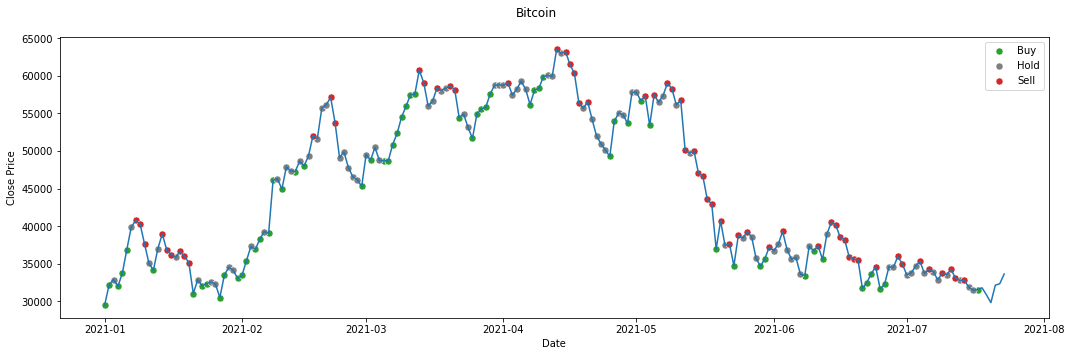

In [24]:
# Plot 2021 close prices for BTC
fig, ax = plt.subplots(figsize=(15,5))
btc_filtered = btc.loc['2021-01-01':]
decision_plot(btc_filtered, ax)

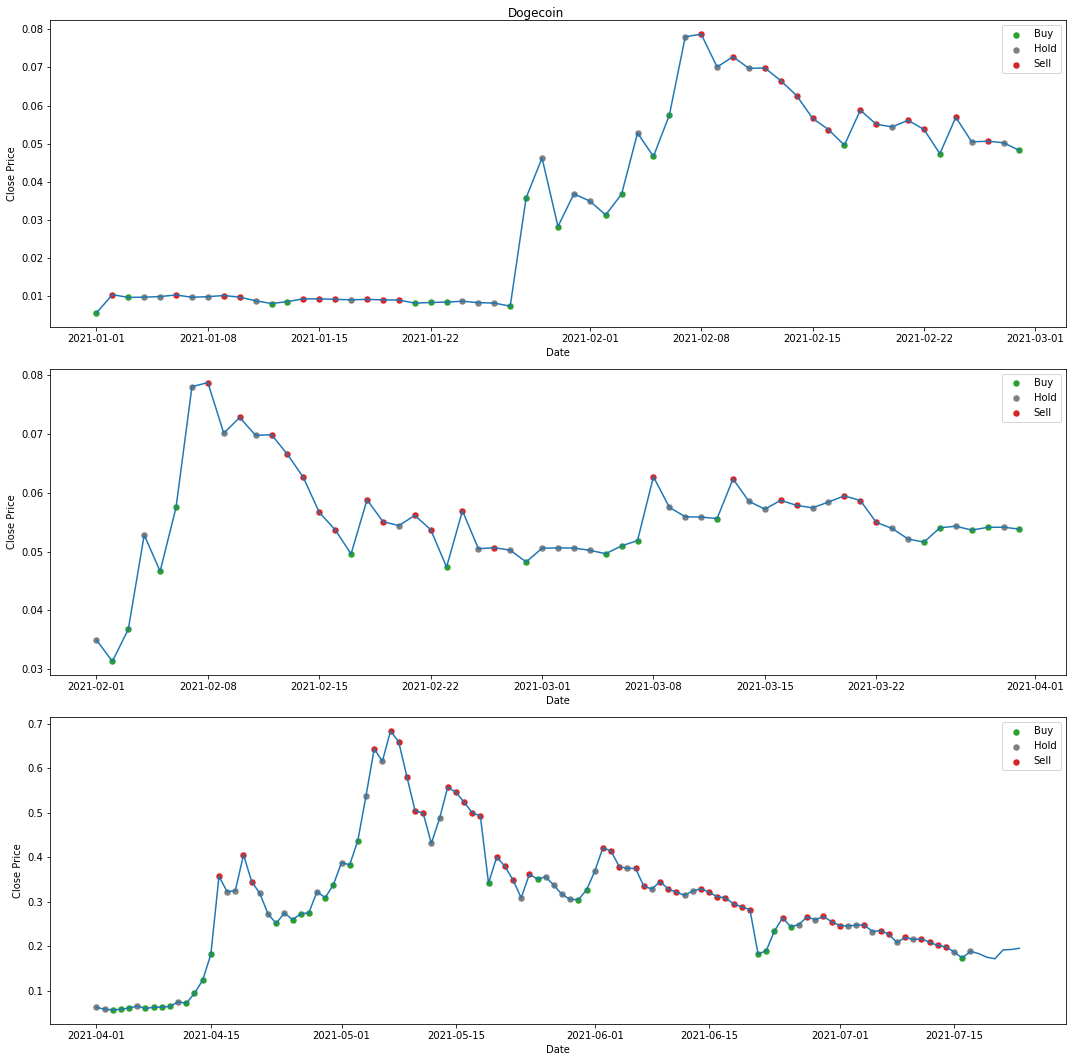

In [25]:
# Plot 2021 close prices for DOGE
fig, ax = plt.subplots(3,1, figsize=(15,15))
doge_filtered = doge.loc['2021-01-01':'2021-02-28']
decision_plot(doge_filtered, ax[0])
doge_filtered = doge.loc['2021-02-01':'2021-03-31']
decision_plot(doge_filtered, ax[1])
doge_filtered = doge.loc['2021-04-01':]
decision_plot(doge_filtered, ax[2])

The Buy/Hold/Sell decision logic for BTC is pretty effective at recommending to buy at the bottom of the trough or as the price is going up and then recommending to sell at the peak or just before the peak.  I split up the DOGE charts just to get a better visual due to large price swings since January 2021.

## 1.5 Save Data

I will save the data for the exploratory data analysis and modeling stages to avoid the time period changing.

In [26]:
interim_dir = r'..\data\interim'
btc.to_csv(os.path.join(interim_dir, 'btc.csv'))
doge.to_csv(os.path.join(interim_dir, 'doge.csv'))